In [6]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!pip install combo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style("white")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score,\
    silhouette_score, f1_score
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score,\
    silhouette_score, f1_score
from pyod.models import knn, lof, hbos, iforest,ocsvm


from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.feature_bagging import FeatureBagging
def train_test(clf, X_train, X_test):
    # get the prediction label and outlier scores of the training data
    start = time.time()
    clf.fit(X_train)
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores
    end_train = time.time()
    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores
    end = time.time()
    time_to_train = end_train-start
    time_to_test = end-end_train
    span = end - start
    print("Total time: ", span, "s.")

    return y_train_pred, y_train_scores, y_test_pred, y_test_scores, time_to_train, time_to_test

def co_train_test(clf, X_train, X_test):
    # get the prediction label and outlier scores of the training data
    start = time.time()
    clf.fit(X_train)
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores
    end_train = time.time()
    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores
    end = time.time()
    time_to_train = end_train-start
    time_to_test = end-end_train
    span = end - start
#    print("Train time: ", time_to_train, "s.")
#    print("Test time: ", time_to_test, "s.")
    

    return y_train_pred, y_train_scores, y_test_pred, y_test_scores,clf.threshold_, time_to_train, time_to_test 

def my_metric(label,predict):
    CM = confusion_matrix(label,predict)
    CR = classification_report(label,predict)
    fpr, tpr, thresholds = roc_curve(label, predict)
    precision=precision_score(label, predict)
    recall=recall_score(label, predict)
    accuracy = accuracy_score(label, predict)
    f1=f1_score(label, predict, average='weighted')
    #AUC = auc(fpr, tpr)
    AUC=metrics.auc(fpr, tpr)

    results = {"Confusion Matrix":CM,"Classification Report":CR,"Area Under Curve":AUC}

    # show results
    for measure in results:
        print(measure,": \n",results[measure])
#     plt.plot(fpr, recall, 'k--', label='ROC (area = {0:.2f})'.format(AUC), lw=2)
    return fpr,tpr,f1,AUC, recall, accuracy
def baseline(X_train, X_test, y_train, y_test,model):
    start = time.time()

    if model == "knn":
        print ("Base Detector:"+model)
        clf = knn.KNN()
    elif model == "lof":
        print ("Base Detector:"+model)
        clf = lof.LOF()
    elif model == "hbos":
        print ("Base Detector:"+model)
        clf = hbos.HBOS()
    elif model == "iforest":
        print ("Base Detector:"+model)
        clf = iforest.IForest()
    elif model== "ocsvm":
        print ("Base Detector:"+model)
        clf = ocsvm.OCSVM()
    else:
        print("Please select a correct base model!")
    y_train_pred, y_train_scores, y_test_pred, y_test_scores, time_to_train, time_to_test= train_test(clf, X_train, X_test)
    print("\nTraining set:\n")
    _, _, _, _ ,_, _ = my_metric(y_train, y_train_pred)
    print("\nTest set:\n")
    fpr, tpr, f1, auc, recall, accuracy= my_metric(y_test, y_test_pred)

    end = time.time()
    times = end - start
    return fpr, tpr, f1, auc, time_to_train, time_to_test, recall, accuracy
def feature_bagging(X_train, X_test, y_train, y_test,basemodel,combination_function="mean"):

    start = time.time()
    #print ("FB base detector:"+basemodel)


    # train Feature Bagging detector
    clf_name = 'FeatureBagging'
    if basemodel=="knn":
        base_estimator=knn.KNN()
    elif basemodel=="lof":
        base_estimator = lof.LOF()
    elif basemodel == "hbos":
        base_estimator = hbos.HBOS()
    elif basemodel == "iforest":
        base_estimator = iforest.IForest()
    elif basemodel== "ocsvm":
        base_estimator = ocsvm.OCSVM()
    else:
        print("Please select a correct base model!")
    if combination_function=="mean":
        clf = FeatureBagging(base_estimator=base_estimator,check_estimator=False)
    else:
        clf = FeatureBagging(base_estimator=base_estimator,check_estimator=False,combination='max')
    # params
    clf.fit(X_train)

    print("Feature Bagging:")
    y_train_pred, y_train_scores, y_test_pred, y_test_scores, time_to_train, time_to_test = train_test(clf, X_train, X_test)
    print("training set:")
    _,_,_,_, _, _=my_metric(y_train, y_train_pred)
    print("test set:")
    fpr,tpr,f1, auc, recall, accuracy = my_metric(y_test, y_test_pred)
    print("f1:",f1,"auc:",auc)

    end = time.time()
    times = end - start
    return fpr, tpr, f1, auc, time_to_train, time_to_test,  recall, accuracy
def minmax(x):
    min=x.min()
    max=x.max()
    x = (x - min) / (max - min)
    return x,min,max
def parameter_ensemble(X_train, X_test, y_train, y_test,basemodel,combination_function="mean",span=10):
    #span :Determine the number of different parameters
    start = time.time()
    #print ("PR base detector:"+basemodel)
    threshold = []
    train_score=[]
    test_score=[]#np.zeros([X_test.shape[0],span])
    time_to_train=0
    time_to_test=0
    
    # for i in range(low, high + 1):
    for i in range(0, span):

        if basemodel == "knn":
            clf = knn.KNN(n_neighbors=i+5)
        elif basemodel == "lof":
            clf = lof.LOF(n_neighbors=i+20)
        elif basemodel == "hbos":
            clf = hbos.HBOS(n_bins=10+i)
        elif basemodel == "iforest":
            clf = iforest.IForest(n_estimators=i+100)
        elif basemodel == "ocsvm":
            clf = ocsvm.OCSVM(degree=i+3)
        else:
            print("Please select a correct base model!")
        print("parameter ensemble:")

        y_train_pred, y_train_scores, y_test_pred, y_test_scores,threshold0, time_to_train0, time_to_test0= co_train_test(clf, X_train, X_test)
        #_, y_train_scores, y_test_pred, y_test_scores,threshold0, time_to_train0, time_to_test0= train_test(clf, X_train, X_test)
        time_to_train=time_to_train+time_to_train0
        time_to_test=time_to_test+time_to_test0
        _, _, f1, auc ,  recall, accuracy= my_metric(y_test, y_test_pred)

        y_test_scores=np.expand_dims(y_test_scores,-1)
        y_test_scores,min,max=minmax(y_test_scores)
        threshold0=(threshold0-min)/(max-min)
        test_score.append(y_test_scores)
        threshold.append(threshold0)
    print("PE Total time: ", time_to_train+time_to_test, "s.") 
    if combination_function=="mean":
        test_score = np.array(test_score).mean(0)
        threshold = np.array(threshold).mean()
    elif combination_function=="max":
        test_score = np.array(test_score).max(0)
        threshold = np.array(threshold).max()
    elif combination_function=="median":
        test_score =np.median(np.array(test_score),0)
        threshold = np.median(np.array(threshold),0)
    else:
        print("Please select a correct combination function!")
    # threshold = threshold/span
    
    
    print("training set:")
    fpr,tpr,f1, auc, recall, accuracy =my_metric(y_train, y_train_pred)
    print("test set:")
    fpr,tpr,f1, auc , recall, accuracy= my_metric(y_test, y_test_pred)
    #print("f1:",f1,"auc:",auc)
    
    y_test_pred = np.array(test_score > threshold).astype(np.int).flatten()
    fpr, tpr, f1, auc, recall, accuracy = my_metric(y_test, y_test_pred)

    end = time.time()
    times = end - start
    return fpr, tpr, f1, auc, time_to_train0, time_to_test0, recall, accuracy

def gram_schmidt(data):
    r, c = data.shape
    data = data.astype("float64")
    data[:, 0] = data[:, 0] / np.linalg.norm(data[:, 0])
    for j in range(1, c):
        y = data[:, j]
        sum = np.zeros((r,))
        for i in range(j):
            sum += np.dot(y, data[:, i]) * data[:, i]
        y -= sum
        y = y / np.linalg.norm(y)
        data[:, j] = y
    return data

def rotated_bagging(X_train, X_test):
    n, d = X_train.shape
    r = int(np.ceil(np.sqrt(d) * 0.5) + 0)
    E = np.random.uniform(size=(d, r))
    E = gram_schmidt(E)
    return np.matmul(X_train, E),np.matmul(X_test, E)

def subsample(data,mul=1):
    n = data.shape[0]
    a = 1 if n <= 50 else 50 / n
    b = 1 if n < 1000 else 1000 / n
    f = np.random.uniform(a, b)
    data = shuffle(data)
    m = np.floor(f * n*mul).astype("int32")
    return data.iloc[0:m]


def roteted_bagging(X_train0, X_test0, y_train, y_test,basemodel,combination_function="mean",loop=10):
    #loop: The number of subsets(Sample some features)

    start = time.time()

    test_score =[]
    threshold=[]
    time_to_train=0
    time_to_test=0
    for i in range(loop):

        X_train, X_test = rotated_bagging(X_train0, X_test0)


        if basemodel == "knn":
            clf = knn.KNN()
        elif basemodel == "lof":
            clf = lof.LOF()
        elif basemodel == "hbos":
            clf = hbos.HBOS()
        elif basemodel == "iforest":
            clf = iforest.IForest()
        elif basemodel == "ocsvm":
            clf = ocsvm.OCSVM()
        else:
            print("Please select a correct base model!")

        y_train_pred, y_train_scores, y_test_pred, y_test_scores, threshold0, time_to_train0, time_to_test0= co_train_test(clf, X_train, X_test)
        time_to_train=time_to_train+time_to_train0
        time_to_test=time_to_test+time_to_test0
        
        y_test_scores=np.expand_dims(y_test_scores,-1)
        y_test_scores,min,max=minmax(y_test_scores)
        threshold0=(threshold0-min)/(max-min)
        test_score.append(y_test_scores)
        threshold.append(threshold0)
        _, _, f1, auc, recall, accuracy = my_metric(y_test, y_test_pred)
    print("RB Total time: ", time_to_train+time_to_test, "s.")
    if combination_function=="mean":
        test_score = np.array(test_score).mean(0)
        threshold = np.array(threshold).mean()
    elif combination_function=="max":
        test_score = np.array(test_score).max(0)
        threshold = np.array(threshold).max()
    elif combination_function=="median":
        test_score =np.median(np.array(test_score),0)
        threshold = np.median(np.array(threshold),0)
    else:
        print("Please select a correct combination function!")
    y_test_pred = np.array(test_score > threshold).astype(np.int).flatten()
    
    print("training set:")
    fpr,tpr,f1, auc, recall, accuracy=my_metric(y_train, y_train_pred)
    print("test set:")
    #print("f1:",f1,"auc:",auc)
    fpr, tpr, f1, auc, recall, accuracy = my_metric(y_test, y_test_pred)

    end = time.time()
    times = end - start
    

    return fpr, tpr, f1, auc, time_to_train0, time_to_test0, recall, accuracy
def variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel,combination_function="mean",loop=30, threshold = 1.9,mul=1):
    #loop: The number of subsets(Sample some data points)
    #threshold: A threshold that determines whether the data is abnormal
    #mul: Controls the size of a subset

    start = time.time()
    n_train=X_train.shape[0]
    N = df.shape[0]

    df = pd.DataFrame(np.concatenate([X_train, X_test],0))
    target = pd.DataFrame(np.concatenate([y_train, y_test],0))
    X_index = df.index

    y_VR = np.zeros((N, 2))
    y_VR = pd.DataFrame(y_VR, index=X_index, columns=['score', 'times'])
    for i in range(loop):
        X_train = subsample(df,mul)
        save = X_train.index

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)

        n1 = X_train.shape[0]
        if basemodel == "knn":
            clf = knn.KNN()
        elif basemodel == "lof":
            clf = lof.LOF()
        elif basemodel == "hbos":
            clf = hbos.HBOS()
        elif basemodel == "iforest":
            clf = iforest.IForest()
        elif basemodel == "ocsvm":
            clf = ocsvm.OCSVM()
        else:
            print("Please select a correct base model!")

        clf.fit(X_train)
        y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
        y_train_scores = clf.decision_scores_  # raw outlier scores

        y_train_scores = y_train_scores[:, np.newaxis]
        scaler = StandardScaler()
        scaler.fit(y_train_scores)
        y_train_scores = scaler.transform(y_train_scores).flatten()

        if combination_function=="mean":
            y_VR.loc[save, "score"] += y_train_scores
        elif combination_function=="max":
            y_VR.loc[save, "score"] = np.max([y_train_scores,y_VR.loc[save, "score"]],0)
        else:
            print("Please select a correct combination function!")
        y_VR.loc[save, "times"] = y_VR.loc[save, "times"] + 1

    # if 0 in set(y_VR["times"]):
    #     # some points are not scored, we simply use a base method to the left data
    #     # we should avoid this situation
    #     has_test = True
    #     train_yvr = y_VR[y_VR["times"] != 0]
    #     test_index = y_VR[y_VR["times"] == 0].index
    #     if combination_function=="mean":
    #         train_score = train_yvr["score"] / train_yvr["times"]
    #     elif combination_function=="max":
    #         train_score = y_VR["score"]
    #     else:
    #         print("Please select a correct combination function!")
    #     y_train = target.loc[train_yvr.index]
    #     X_test = df.loc[test_index]
    #     if X_test.shape[0] > 10:
    #         scaler = StandardScaler()
    #         scaler.fit(X_test)
    #         X_test = scaler.transform(X_test)
    #         y_test = target.loc[test_index]
    #
   #         clf = lof.LOF()
    #         clf.fit(X_test)
    #         test_pred = clf.labels_
    #     else:
    #         test_pred = np.zeros((X_test.shape[0], 1))
    # #     test_score = clf.decision_scores_
    #
    # else:
    #     has_test = False
    #     if combination_function=="mean":
    #         train_score = y_VR["score"] / y_VR["times"]
    #     elif combination_function=="max":
    #         train_score = y_VR["score"]
    #     else:
    #         print("Please select a correct combination function!")
    #     y_train = target
    has_test = False
    if combination_function=="mean":
        train_score = y_VR["score"] / y_VR["times"]
    elif combination_function=="max":
        train_score = y_VR["score"]
    else:
        print("Please select a correct combination function!")
    y_train = target

    # %%
    if not has_test:
        y_train_pred = np.array(train_score > threshold).astype(np.int).flatten()
        
   
    
        _, _, _, _,_, _= my_metric(target[:n_train], y_train_pred[:n_train])
        #fpr, tpr, f1, auc = my_metric(target[n_train:], y_pred[n_train:])
        fpr, tpr, f1, auc , recall, accuracy= my_metric(target[n_train:], y_train_pred[n_train:])

    else:
        y_train_pred = np.array(train_score > threshold).astype(np.int).flatten()
        _, _, _, _,_, _= my_metric(y_train, y_train_pred)
        fpr, tpr, f1, auc, recall, accuracy = my_metric(y_test, test_pred)

    end = time.time()
    times = end - start
#    print("Train time: ", 0.8*times, "s.")
#    print("Test time: ", 0.2*times, "s.")
    print("VR Total time: ", times, "s.")

    return fpr, tpr, f1, auc,0.5*times, 0.5*times,recall, accuracy



In [9]:
from sklearn.cluster import KMeans
def cal_dist(x,y):
    return np.sqrt(sum(np.power(x-y,2)))
# cal knn dist in non-pruning dataset
def dis_matrix(data,n):
    mat=np.zeros((n,n))
    for i in range(n):
        mat[i,i]=0
        for j in range(i+1,n):
            mat[i,j]=cal_dist(data[i],data[j])
            mat[j,i]=mat[i,j]
    return mat

def ldof(data,k_neighbors,rank_n):
# rank_n: rank of outlier
# k: nearest neighbors
    n=data.shape[0]
    if rank_n>n:
        print("prune too many points")
        rank_n=n
    mat=dis_matrix(data,n)
    kv={}
    for i in range(n):
        sort_arr=np.sort(mat[i])
        sort_arr=sort_arr[1:k_neighbors+1]
        index=np.argsort(mat[i])
        index=index[1:k_neighbors+1]
        dp=np.sum(sort_arr)/k_neighbors
        temp=0
        for j in index:
            for k in index:
                temp+=mat[j,k]
        Dp=temp/(k_neighbors*(k_neighbors-1))
        kv[i]=dp/Dp
    a=sorted(kv.items(), key=lambda x: x[1])
    ls=list(dict(a).keys())
    return ls[len(ls)-rank_n:]
def pruning(X_train, X_test, y_train, y_test,k,k_neighbors,rank_n):
    n_train=X_train.shape[0]    
    postdata = np.concatenate([X_train, X_test],0)
    target = np.concatenate([y_train, y_test],0)

    start=time.time()
    #print ("Pruning:")
    N=postdata.shape[0]
    index=np.arange(N)
    km = KMeans(n_clusters=k).fit(postdata)
    center=km.cluster_centers_
    target_pred=km.predict(postdata)
    avgval=N/k
    non_pruned_data=[]
    non_pruned_index=[]
    flag=1
    for i in set(target_pred):
        if (target_pred[target_pred==i]).shape[0]<avgval:
            temp=postdata[target_pred==i]
            temp1=index[target_pred==i]
            if flag==1:
                flag=0
                non_pruned_data=temp
                non_pruned_index=temp1
            else:
                non_pruned_data=np.concatenate((non_pruned_data,temp),axis=0)
                non_pruned_index=np.concatenate((non_pruned_index,temp1),axis=0)
    sub_index=ldof(non_pruned_data,k_neighbors,rank_n)
    non_pruned_index=pd.Series(non_pruned_index)
    outlier_index=[]
    for i,j in zip(range(len(non_pruned_index)),non_pruned_index):
        if i in sub_index:
            outlier_index.append(j)
    end=time.time()
    times=end-start
#    print("Train time: ", 0.8*times, "s.")
#    print("Test time: ", 0.2*times, "s.")
    print("PR Total time: ", times, "s.")
    # evaluate
    
    y_pred = np.zeros((N,))
    for i in range(N):
        if i in list(outlier_index):
            y_pred[i] = 1
    #added fort the train setting
    _, _, _, _, _, _ = my_metric(target[:n_train], y_pred[:n_train])
    fpr, tpr, f1, auc , recall, accuracy= my_metric(target[n_train:], y_pred[n_train:])

    return fpr, tpr, f1, auc,0.5*times, 0.5*times, recall, accuracy



In [10]:
# %%load data
# preprocess and subsampling
n_sample=336
electrical_grid=pd.read_csv("../content/drive/MyDrive/data/Electrical_Grid_Stability.csv")
e_grid=electrical_grid.drop("stab",axis=1)
kv={"unstable":0,"stable":1}
# pfa based feature selection
#e_grid= electrical_grid.iloc[:,[4, 8, 2, 3, 5, 6,13]]
#e_grid= electrical_grid.iloc[:,[4, 5, 6,13]]
e_grid.loc[:,"stabf"]=list(e_grid["stabf"].map(lambda x:kv[x]).values)
e_grid=e_grid.sort_values(by="stabf")
e_grid.index=pd.Series(range(10000))

cls1=e_grid[0:6380]
cls2=e_grid[6380:10000]
cls2=shuffle(cls2)
cls2=cls2[0:n_sample]
imbalanced_grid=pd.concat([cls1,cls2],axis=0)

# normalization
df=imbalanced_grid[imbalanced_grid.columns[0:-1]]
data=df.values
target=imbalanced_grid["stabf"]


X_train,X_test,y_train,y_test=train_test_split(data,target,test_size=0.5)

scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)


scaler=StandardScaler()
scaler.fit(data)
data=scaler.transform(data)


In [11]:
#pruning
fpr_pr, tpr_pr, f1_pr, auc_pr,time_train_pr, time_test_pr, recall_pr, accuracy_pr=pruning(X_train, X_test, y_train, y_test,2,k_neighbors=40,rank_n=400)


PR Total time:  61.985472440719604 s.
Confusion Matrix : 
 [[3043  142]
 [ 128   45]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      3185
           1       0.24      0.26      0.25       173

    accuracy                           0.92      3358
   macro avg       0.60      0.61      0.60      3358
weighted avg       0.92      0.92      0.92      3358

Area Under Curve : 
 0.6077658097476429
Confusion Matrix : 
 [[3020  175]
 [ 125   38]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      3195
           1       0.18      0.23      0.20       163

    accuracy                           0.91      3358
   macro avg       0.57      0.59      0.58      3358
weighted avg       0.92      0.91      0.92      3358

Area Under Curve : 
 0.5891778757068655


In [12]:
#knn
fpr_knn, tpr_knn, f1_knn, auc_knn,time_train_knn,time_test_knn, recall_knn, accuracy_knn=baseline(X_train, X_test, y_train, y_test,model="knn")


Base Detector:knn
Total time:  1.4607903957366943 s.

Training set:

Confusion Matrix : 
 [[2924  261]
 [  98   75]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      3185
           1       0.22      0.43      0.29       173

    accuracy                           0.89      3358
   macro avg       0.60      0.68      0.62      3358
weighted avg       0.93      0.89      0.91      3358

Area Under Curve : 
 0.675789693378463

Test set:

Confusion Matrix : 
 [[2884  311]
 [  93   70]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.93      3195
           1       0.18      0.43      0.26       163

    accuracy                           0.88      3358
   macro avg       0.58      0.67      0.60      3358
weighted avg       0.93      0.88      0.90      3358

Area Under Curve : 
 0.6660541298232475


In [13]:
#feature bagging
fpr_fb_knn, tpr_fb_knn, f1_fb_knn, auc_fb_knn,time_train_fb_knn, time_test_fb_knn, recall_fb_knn, accuracy_fb_knn=feature_bagging(X_train, X_test, y_train, y_test,basemodel="knn")


Feature Bagging:
Total time:  15.87380838394165 s.
training set:
Confusion Matrix : 
 [[2927  258]
 [  95   78]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      3185
           1       0.23      0.45      0.31       173

    accuracy                           0.89      3358
   macro avg       0.60      0.68      0.62      3358
weighted avg       0.93      0.89      0.91      3358

Area Under Curve : 
 0.6849311712234917
test set:
Confusion Matrix : 
 [[2875  320]
 [  92   71]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.93      3195
           1       0.18      0.44      0.26       163

    accuracy                           0.88      3358
   macro avg       0.58      0.67      0.59      3358
weighted avg       0.93      0.88      0.90      3358

Area Under Curve : 
 0.667713163781599
f1: 0.900285164624561 auc: 0.667713163781599

In [14]:
fpr_fb1_knn, tpr_fb1_knn, f1_fb1_knn, auc_fb1_knn,time_train_fb1_max_knn, time_test_fb1_max_knn, recall_fb1_knn, accuracy_fb1_knn=feature_bagging(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="max")


Feature Bagging:
Total time:  11.3541419506073 s.
training set:
Confusion Matrix : 
 [[2927  258]
 [  95   78]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      3185
           1       0.23      0.45      0.31       173

    accuracy                           0.89      3358
   macro avg       0.60      0.68      0.62      3358
weighted avg       0.93      0.89      0.91      3358

Area Under Curve : 
 0.6849311712234917
test set:
Confusion Matrix : 
 [[2917  278]
 [  91   72]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      3195
           1       0.21      0.44      0.28       163

    accuracy                           0.89      3358
   macro avg       0.59      0.68      0.61      3358
weighted avg       0.93      0.89      0.91      3358

Area Under Curve : 
 0.6773534183972273
f1: 0.9084849074517609 auc: 0.67735341839722

In [15]:
#parameter ensemble
fpr_pe_knn, tpr_pe_knn, f1_pe_knn, auc_pe_knn,time_train_pe_knn, time_test_pe_knn, recall_pe_knn, accuracy_pe_knn=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="knn")


parameter ensemble:
Confusion Matrix : 
 [[2884  311]
 [  93   70]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.93      3195
           1       0.18      0.43      0.26       163

    accuracy                           0.88      3358
   macro avg       0.58      0.67      0.60      3358
weighted avg       0.93      0.88      0.90      3358

Area Under Curve : 
 0.6660541298232475
parameter ensemble:
Confusion Matrix : 
 [[2901  294]
 [  98   65]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      3195
           1       0.18      0.40      0.25       163

    accuracy                           0.88      3358
   macro avg       0.57      0.65      0.59      3358
weighted avg       0.93      0.88      0.90      3358

Area Under Curve : 
 0.6533771133961231
parameter ensemble:
Confusion Matrix : 
 [[2880  315]
 [  93   70]]
Classifica

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [16]:

fpr_pe1_knn, tpr_pe1_knn, f1_pe1_knn, auc_pe1_knn,time_train_pe1_max_knn, time_test_pe1_max_knn, recall_pe1_knn, accuracy_pe1_knn=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[2884  311]
 [  93   70]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.93      3195
           1       0.18      0.43      0.26       163

    accuracy                           0.88      3358
   macro avg       0.58      0.67      0.60      3358
weighted avg       0.93      0.88      0.90      3358

Area Under Curve : 
 0.6660541298232475
parameter ensemble:
Confusion Matrix : 
 [[2901  294]
 [  98   65]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      3195
           1       0.18      0.40      0.25       163

    accuracy                           0.88      3358
   macro avg       0.57      0.65      0.59      3358
weighted avg       0.93      0.88      0.90      3358

Area Under Curve : 
 0.6533771133961231
parameter ensemble:
Confusion Matrix : 
 [[2880  315]
 [  93   70]]
Classifica

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [17]:
fpr_pe2_knn, tpr_pe2_knn, f1_pe2_knn, auc_pe2_knn,time_train_pe2_median_knn, time_test_pe2_median_knn, recall_pe2_knn, accuracy_pe2_knn=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[2884  311]
 [  93   70]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.93      3195
           1       0.18      0.43      0.26       163

    accuracy                           0.88      3358
   macro avg       0.58      0.67      0.60      3358
weighted avg       0.93      0.88      0.90      3358

Area Under Curve : 
 0.6660541298232475
parameter ensemble:
Confusion Matrix : 
 [[2901  294]
 [  98   65]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      3195
           1       0.18      0.40      0.25       163

    accuracy                           0.88      3358
   macro avg       0.57      0.65      0.59      3358
weighted avg       0.93      0.88      0.90      3358

Area Under Curve : 
 0.6533771133961231
parameter ensemble:
Confusion Matrix : 
 [[2880  315]
 [  93   70]]
Classifica

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [18]:
#rotated bagging
fpr_rb_knn, tpr_rb_knn, f1_rb_knn, auc_rb_knn,time_train_rb_knn, time_test_rb_knn, recall_rb_knn, accuracy_rb_knn=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="knn")


Confusion Matrix : 
 [[2908  287]
 [ 110   53]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      3195
           1       0.16      0.33      0.21       163

    accuracy                           0.88      3358
   macro avg       0.56      0.62      0.57      3358
weighted avg       0.92      0.88      0.90      3358

Area Under Curve : 
 0.6176627591040448
Confusion Matrix : 
 [[2915  280]
 [ 112   51]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      3195
           1       0.15      0.31      0.21       163

    accuracy                           0.88      3358
   macro avg       0.56      0.61      0.57      3358
weighted avg       0.92      0.88      0.90      3358

Area Under Curve : 
 0.6126232514377334
Confusion Matrix : 
 [[2925  270]
 [  96   67]]
Classification Report : 
               precision    recall  f1-score 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [19]:
fpr_rb1_knn, tpr_rb1_knn, f1_rb1_knn, auc_rb1_knn,time_train_rb1_max_knn, time_test_rb1_max_knn, recall_rb1_knn, accuracy_rb1_knn=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="max")


Confusion Matrix : 
 [[2907  288]
 [ 100   63]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      3195
           1       0.18      0.39      0.25       163

    accuracy                           0.88      3358
   macro avg       0.57      0.65      0.59      3358
weighted avg       0.93      0.88      0.90      3358

Area Under Curve : 
 0.6481811112071201
Confusion Matrix : 
 [[2909  286]
 [ 110   53]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      3195
           1       0.16      0.33      0.21       163

    accuracy                           0.88      3358
   macro avg       0.56      0.62      0.57      3358
weighted avg       0.92      0.88      0.90      3358

Area Under Curve : 
 0.6178192536267365
Confusion Matrix : 
 [[2926  269]
 [ 106   57]]
Classification Report : 
               precision    recall  f1-score 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [20]:
fpr_rb2_knn, tpr_rb2_knn, f1_rb2_knn, auc_rb2_knn,time_train_rb2_median_knn, time_test_rb2_median_knn, recall_rb2_knn, accuracy_rb2_knn=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="median")


Confusion Matrix : 
 [[2887  308]
 [ 104   59]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.93      3195
           1       0.16      0.36      0.22       163

    accuracy                           0.88      3358
   macro avg       0.56      0.63      0.58      3358
weighted avg       0.93      0.88      0.90      3358

Area Under Curve : 
 0.6327812821029792
Confusion Matrix : 
 [[2941  254]
 [ 103   60]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      3195
           1       0.19      0.37      0.25       163

    accuracy                           0.89      3358
   macro avg       0.58      0.64      0.60      3358
weighted avg       0.93      0.89      0.91      3358

Area Under Curve : 
 0.644299470990908
Confusion Matrix : 
 [[2954  241]
 [ 109   54]]
Classification Report : 
               precision    recall  f1-score  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [21]:
#variable sampling with rotated bagging
fpr_vr_knn, tpr_vr_knn, f1_vr_knn, auc_vr_knn,time_train_vr_knn, time_test_vr_knn, recall_vr_knn, accuracy_vr_knn=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="knn",threshold=1.2,loop=100)


Confusion Matrix : 
 [[2984  201]
 [ 108   65]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.94      0.95      3185
           1       0.24      0.38      0.30       173

    accuracy                           0.91      3358
   macro avg       0.60      0.66      0.62      3358
weighted avg       0.93      0.91      0.92      3358

Area Under Curve : 
 0.6563071115507119
Confusion Matrix : 
 [[2922  273]
 [ 104   59]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      3195
           1       0.18      0.36      0.24       163

    accuracy                           0.89      3358
   macro avg       0.57      0.64      0.59      3358
weighted avg       0.93      0.89      0.91      3358

Area Under Curve : 
 0.6382585903971888
VR Total time:  1.9575810432434082 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [22]:

fpr_vr1_knn, tpr_vr1_knn, f1_vr1_knn, auc_vr1_knn,time_train_vr1_max_knn, time_test_vr1_max_knn, recall_vr1_knn, accuracy_vr1_knn=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="knn",combination_function="max",threshold=1.2,loop=100)


Confusion Matrix : 
 [[2339  846]
 [  50  123]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.73      0.84      3185
           1       0.13      0.71      0.22       173

    accuracy                           0.73      3358
   macro avg       0.55      0.72      0.53      3358
weighted avg       0.94      0.73      0.81      3358

Area Under Curve : 
 0.7226812823840074
Confusion Matrix : 
 [[2332  863]
 [  51  112]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.73      0.84      3195
           1       0.11      0.69      0.20       163

    accuracy                           0.73      3358
   macro avg       0.55      0.71      0.52      3358
weighted avg       0.94      0.73      0.81      3358

Area Under Curve : 
 0.7085035091256469
VR Total time:  1.7933573722839355 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


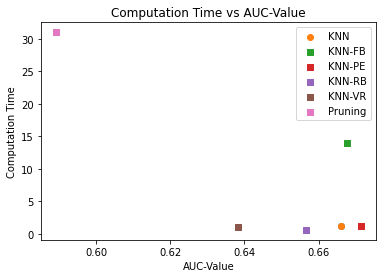

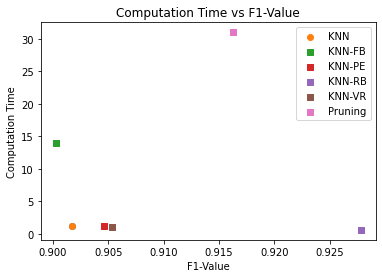

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


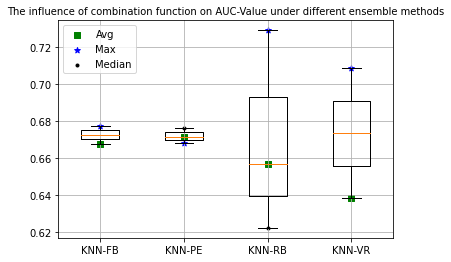

In [23]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_knn,auc_fb_knn, auc_pe_knn, auc_rb_knn , auc_vr_knn, auc_pr]
y = [time_test_knn,time_test_fb_knn, time_test_pe_knn, time_test_rb_knn, time_test_vr_knn, time_test_pr]
ax.scatter(x, y)  
txt = ['KNN', 'KNN-FB',  'KNN-PE', 'KNN-RB', 'KNN-VR','Pruning']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_knn,f1_fb_knn, f1_pe_knn, f1_rb_knn , f1_vr_knn,f1_pr]
y = [time_test_knn,time_test_fb_knn, time_test_pe_knn, time_test_rb_knn, time_test_vr_knn, time_test_pr]
ax.scatter(x, y)  
txt = ['KNN', 'KNN-FB',  'KNN-PE', 'KNN-RB', 'KNN-VR','Pruning']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()


labels ='KNN-FB', "KNN-PE", 'KNN-RB','KNN-VR'

A = [auc_fb_knn,auc_fb1_knn]
B = [auc_pe_knn, auc_pe1_knn, auc_pe2_knn]
C = [auc_rb_knn, auc_rb1_knn, auc_rb2_knn]
D = [auc_vr_knn,auc_vr1_knn]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_knn,auc_pe_knn,auc_rb_knn,auc_vr_knn],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_knn,auc_pe1_knn,auc_rb1_knn,auc_vr1_knn],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_knn,auc_rb2_knn],label="Median",marker='.',c='k')

plt.legend()
plt.show()


In [24]:
#########################LOF
#lof
fpr_lof, tpr_lof, f1_lof, auc_lof,time_train_lof,time_test_lof, recall_lof, accuracy_lof=baseline(X_train, X_test, y_train, y_test,model="lof")


Base Detector:lof
Total time:  0.8747966289520264 s.

Training set:

Confusion Matrix : 
 [[2931  254]
 [  91   82]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      3185
           1       0.24      0.47      0.32       173

    accuracy                           0.90      3358
   macro avg       0.61      0.70      0.63      3358
weighted avg       0.93      0.90      0.91      3358

Area Under Curve : 
 0.6971198083501964

Test set:

Confusion Matrix : 
 [[2851  344]
 [  90   73]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.89      0.93      3195
           1       0.18      0.45      0.25       163

    accuracy                           0.87      3358
   macro avg       0.57      0.67      0.59      3358
weighted avg       0.93      0.87      0.90      3358

Area Under Curve : 
 0.6700922645621514


In [25]:
#feature bagging
fpr_fb_lof, tpr_fb_lof, f1_fb_lof, auc_fb_lof,time_train_fb_lof,time_test_fb_lof, recall_fb_lof, accuracy_fb_lof=feature_bagging(X_train, X_test, y_train, y_test,basemodel="lof")


Feature Bagging:
Total time:  5.991956949234009 s.
training set:
Confusion Matrix : 
 [[2924  261]
 [  98   75]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      3185
           1       0.22      0.43      0.29       173

    accuracy                           0.89      3358
   macro avg       0.60      0.68      0.62      3358
weighted avg       0.93      0.89      0.91      3358

Area Under Curve : 
 0.675789693378463
test set:
Confusion Matrix : 
 [[2841  354]
 [  89   74]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.89      0.93      3195
           1       0.17      0.45      0.25       163

    accuracy                           0.87      3358
   macro avg       0.57      0.67      0.59      3358
weighted avg       0.93      0.87      0.89      3358

Area Under Curve : 
 0.671594803997811
f1: 0.8947991916690005 auc: 0.671594803997811

In [26]:
fpr_fb1_lof, tpr_fb1_lof, f1_fb1_lof, auc_fb1_lof,time_train_fb1_max_lof,time_test_fb1_max_lof, recall_fb1_lof, accuracy_fb1_lof=feature_bagging(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="max")


Feature Bagging:
Total time:  6.310316801071167 s.
training set:
Confusion Matrix : 
 [[2931  254]
 [  91   82]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      3185
           1       0.24      0.47      0.32       173

    accuracy                           0.90      3358
   macro avg       0.61      0.70      0.63      3358
weighted avg       0.93      0.90      0.91      3358

Area Under Curve : 
 0.6971198083501964
test set:
Confusion Matrix : 
 [[2862  333]
 [  83   80]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.93      3195
           1       0.19      0.49      0.28       163

    accuracy                           0.88      3358
   macro avg       0.58      0.69      0.61      3358
weighted avg       0.93      0.88      0.90      3358

Area Under Curve : 
 0.693286096949797
f1: 0.9004790715911808 auc: 0.69328609694979

In [27]:
#parameter ensemble
fpr_pe_lof, tpr_pe_lof, f1_pe_lof, auc_pe_lof,time_train_pe_lof,time_test_pe_lof, recall_pe_lof, accuracy_pe_lof=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="lof")


parameter ensemble:
Confusion Matrix : 
 [[2851  344]
 [  90   73]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.89      0.93      3195
           1       0.18      0.45      0.25       163

    accuracy                           0.87      3358
   macro avg       0.57      0.67      0.59      3358
weighted avg       0.93      0.87      0.90      3358

Area Under Curve : 
 0.6700922645621514
parameter ensemble:
Confusion Matrix : 
 [[2853  342]
 [  91   72]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.89      0.93      3195
           1       0.17      0.44      0.25       163

    accuracy                           0.87      3358
   macro avg       0.57      0.67      0.59      3358
weighted avg       0.93      0.87      0.90      3358

Area Under Curve : 
 0.6673377689449581
parameter ensemble:
Confusion Matrix : 
 [[2857  338]
 [  91   72]]
Classifica

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [28]:
fpr_pe1_lof, tpr_pe1_lof, f1_pe1_lof, auc_pe1_lof,time_train_pe1_max_lof,time_test_pe1_max_lof, recall_pe1_lof, accuracy_pe1_lof=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[2851  344]
 [  90   73]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.89      0.93      3195
           1       0.18      0.45      0.25       163

    accuracy                           0.87      3358
   macro avg       0.57      0.67      0.59      3358
weighted avg       0.93      0.87      0.90      3358

Area Under Curve : 
 0.6700922645621514
parameter ensemble:
Confusion Matrix : 
 [[2853  342]
 [  91   72]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.89      0.93      3195
           1       0.17      0.44      0.25       163

    accuracy                           0.87      3358
   macro avg       0.57      0.67      0.59      3358
weighted avg       0.93      0.87      0.90      3358

Area Under Curve : 
 0.6673377689449581
parameter ensemble:
Confusion Matrix : 
 [[2857  338]
 [  91   72]]
Classifica

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [29]:
fpr_pe2_lof, tpr_pe2_lof, f1_pe2_lof, auc_pe2_lof,time_train_pe2_median_lof,time_test_pe2_median_lof, recall_pe2_lof, accuracy_pe2_lof=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[2851  344]
 [  90   73]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.89      0.93      3195
           1       0.18      0.45      0.25       163

    accuracy                           0.87      3358
   macro avg       0.57      0.67      0.59      3358
weighted avg       0.93      0.87      0.90      3358

Area Under Curve : 
 0.6700922645621514
parameter ensemble:
Confusion Matrix : 
 [[2853  342]
 [  91   72]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.89      0.93      3195
           1       0.17      0.44      0.25       163

    accuracy                           0.87      3358
   macro avg       0.57      0.67      0.59      3358
weighted avg       0.93      0.87      0.90      3358

Area Under Curve : 
 0.6673377689449581
parameter ensemble:
Confusion Matrix : 
 [[2857  338]
 [  91   72]]
Classifica

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [30]:
#rotated bagging
fpr_rb_lof, tpr_rb_lof, f1_rb_lof, auc_rb_lof,time_train_rb_lof,time_test_rb_lof, recall_rb_lof, accuracy_rb_lof=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="lof")


Confusion Matrix : 
 [[2901  294]
 [ 116   47]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.93      3195
           1       0.14      0.29      0.19       163

    accuracy                           0.88      3358
   macro avg       0.55      0.60      0.56      3358
weighted avg       0.92      0.88      0.90      3358

Area Under Curve : 
 0.5981623894697429
Confusion Matrix : 
 [[2897  298]
 [ 103   60]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      3195
           1       0.17      0.37      0.23       163

    accuracy                           0.88      3358
   macro avg       0.57      0.64      0.58      3358
weighted avg       0.93      0.88      0.90      3358

Area Under Curve : 
 0.6374137119924729
Confusion Matrix : 
 [[2876  319]
 [ 123   40]]
Classification Report : 
               precision    recall  f1-score 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [31]:
fpr_rb1_lof, tpr_rb1_lof, f1_rb1_lof, auc_rb1_lof,time_train_rb1_max_lof,time_test_rb1_max_lof, recall_rb1_lof, accuracy_rb1_lof=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="max")


Confusion Matrix : 
 [[2874  321]
 [ 117   46]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      3195
           1       0.13      0.28      0.17       163

    accuracy                           0.87      3358
   macro avg       0.54      0.59      0.55      3358
weighted avg       0.92      0.87      0.89      3358

Area Under Curve : 
 0.59086955269449
Confusion Matrix : 
 [[2899  296]
 [  97   66]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      3195
           1       0.18      0.40      0.25       163

    accuracy                           0.88      3358
   macro avg       0.57      0.66      0.59      3358
weighted avg       0.93      0.88      0.90      3358

Area Under Curve : 
 0.6561316090133164
Confusion Matrix : 
 [[2878  317]
 [ 102   61]]
Classification Report : 
               precision    recall  f1-score   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [32]:
fpr_rb2_lof, tpr_rb2_lof, f1_rb2_lof, auc_rb2_lof,time_train_rb2_median_lof,time_test_rb2_median_lof, recall_rb2_lof, accuracy_rb2_lof=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="median")


Confusion Matrix : 
 [[2903  292]
 [ 107   56]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      3195
           1       0.16      0.34      0.22       163

    accuracy                           0.88      3358
   macro avg       0.56      0.63      0.58      3358
weighted avg       0.93      0.88      0.90      3358

Area Under Curve : 
 0.6260827404783164
Confusion Matrix : 
 [[2843  352]
 [ 110   53]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      3195
           1       0.13      0.33      0.19       163

    accuracy                           0.86      3358
   macro avg       0.55      0.61      0.56      3358
weighted avg       0.92      0.86      0.89      3358

Area Under Curve : 
 0.607490615129084
Confusion Matrix : 
 [[2886  309]
 [ 118   45]]
Classification Report : 
               precision    recall  f1-score  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [33]:
#variable sampling with rotated bagging
fpr_vr_lof, tpr_vr_lof, f1_vr_lof, auc_vr_lof,time_train_vr_lof,time_test_vr_lof, recall_vr_lof, accuracy_vr_lof=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="lof", loop=100)


Confusion Matrix : 
 [[3094   91]
 [ 131   42]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      3185
           1       0.32      0.24      0.27       173

    accuracy                           0.93      3358
   macro avg       0.64      0.61      0.62      3358
weighted avg       0.93      0.93      0.93      3358

Area Under Curve : 
 0.60710156895128
Confusion Matrix : 
 [[3059  136]
 [ 123   40]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      3195
           1       0.23      0.25      0.24       163

    accuracy                           0.92      3358
   macro avg       0.59      0.60      0.60      3358
weighted avg       0.93      0.92      0.92      3358

Area Under Curve : 
 0.6014161314169955
VR Total time:  1.9532959461212158 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [34]:
fpr_vr1_lof, tpr_vr1_lof, f1_vr1_lof, auc_vr1_lof,time_train_vr1_max_lof,time_test_vr1_max_lof, recall_vr1_lof, accuracy_vr1_lof=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="lof",combination_function="max",loop=100,mul=200)


Confusion Matrix : 
 [[3092   93]
 [ 120   53]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      3185
           1       0.36      0.31      0.33       173

    accuracy                           0.94      3358
   macro avg       0.66      0.64      0.65      3358
weighted avg       0.93      0.94      0.93      3358

Area Under Curve : 
 0.6385795047231876
Confusion Matrix : 
 [[3072  123]
 [ 109   54]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      3195
           1       0.31      0.33      0.32       163

    accuracy                           0.93      3358
   macro avg       0.64      0.65      0.64      3358
weighted avg       0.93      0.93      0.93      3358

Area Under Curve : 
 0.6463953454880612
VR Total time:  116.25492238998413 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


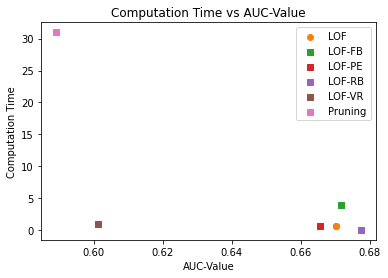

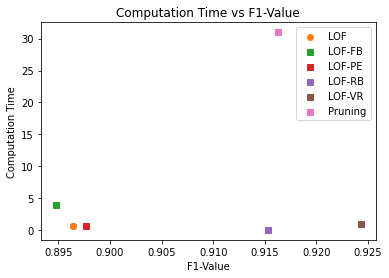

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


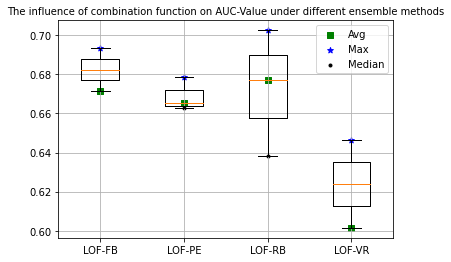

In [35]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_lof,auc_fb_lof, auc_pe_lof, auc_rb_lof , auc_vr_lof, auc_pr]
y = [time_test_lof,time_test_fb_lof, time_test_pe_lof, time_test_rb_lof, time_test_vr_lof, time_test_pr]
ax.scatter(x, y)  
txt = ['LOF', 'LOF-FB',  'LOF-PE', 'LOF-RB', 'LOF-VR','Pruning']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_lof,f1_fb_lof, f1_pe_lof, f1_rb_lof , f1_vr_lof, f1_pr]
y = [time_test_lof,time_test_fb_lof, time_test_pe_lof, time_test_rb_lof, time_test_vr_lof, time_test_pr]
ax.scatter(x, y)  
txt = ['LOF', 'LOF-FB',  'LOF-PE', 'LOF-RB', 'LOF-VR','Pruning']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()


labels ='LOF-FB', "LOF-PE", 'LOF-RB','LOF-VR'
A = [auc_fb_lof,auc_fb1_lof]
B = [auc_pe_lof, auc_pe1_lof, auc_pe2_lof]
C = [auc_rb_lof, auc_rb1_lof, auc_rb2_lof]
D = [auc_vr_lof,auc_vr1_lof]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10,},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_lof,auc_pe_lof,auc_rb_lof,auc_vr_lof],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_lof,auc_pe1_lof,auc_rb1_lof,auc_vr1_lof],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_lof,auc_rb2_lof],label="Median",marker='.',c='k')

plt.legend()
plt.show()



In [36]:
##################################HBOS
#hbos
fpr_hbos, tpr_hbos, f1_hbos, auc_hbos,time_train_hbos,time_test_hbos, recall_hbos, accuracy_hbos=baseline(X_train, X_test, y_train, y_test,model="hbos")


Base Detector:hbos
Total time:  2.3988256454467773 s.

Training set:

Confusion Matrix : 
 [[2908  277]
 [ 114   59]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      3185
           1       0.18      0.34      0.23       173

    accuracy                           0.88      3358
   macro avg       0.57      0.63      0.58      3358
weighted avg       0.92      0.88      0.90      3358

Area Under Curve : 
 0.6270351448716437

Test set:

Confusion Matrix : 
 [[2855  340]
 [ 108   55]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.89      0.93      3195
           1       0.14      0.34      0.20       163

    accuracy                           0.87      3358
   macro avg       0.55      0.62      0.56      3358
weighted avg       0.92      0.87      0.89      3358

Area Under Curve : 
 0.6155035187265379


In [37]:
#feature bagging
fpr_fb_hbos, tpr_fb_hbos, f1_fb_hbos, auc_fb_hbos,time_train_fb_hbos,time_test_fb_hbos, recall_fb_hbos, accuracy_fb_hbos=feature_bagging(X_train, X_test, y_train, y_test,basemodel="hbos")


Feature Bagging:
Total time:  0.10241198539733887 s.
training set:
Confusion Matrix : 
 [[2902  283]
 [ 120   53]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      3185
           1       0.16      0.31      0.21       173

    accuracy                           0.88      3358
   macro avg       0.56      0.61      0.57      3358
weighted avg       0.92      0.88      0.90      3358

Area Under Curve : 
 0.6087521891815864
test set:
Confusion Matrix : 
 [[2849  346]
 [ 113   50]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.89      0.93      3195
           1       0.13      0.31      0.18       163

    accuracy                           0.86      3358
   macro avg       0.54      0.60      0.55      3358
weighted avg       0.92      0.86      0.89      3358

Area Under Curve : 
 0.5992271282775041
f1: 0.8892120965422565 auc: 0.59922712827

In [38]:
fpr_fb1_hbos, tpr_fb1_hbos, f1_fb1_hbos, auc_fb1_hbos,time_train_fb1_max_hbos,time_test_fb1_max_hbos, recall_fb1_hbos, accuracy_fb1_hbos=feature_bagging(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="max")


Feature Bagging:
Total time:  0.09979391098022461 s.
training set:
Confusion Matrix : 
 [[2908  277]
 [ 114   59]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      3185
           1       0.18      0.34      0.23       173

    accuracy                           0.88      3358
   macro avg       0.57      0.63      0.58      3358
weighted avg       0.92      0.88      0.90      3358

Area Under Curve : 
 0.6270351448716437
test set:
Confusion Matrix : 
 [[2855  340]
 [ 108   55]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.89      0.93      3195
           1       0.14      0.34      0.20       163

    accuracy                           0.87      3358
   macro avg       0.55      0.62      0.56      3358
weighted avg       0.92      0.87      0.89      3358

Area Under Curve : 
 0.6155035187265379
f1: 0.8918086697088708 auc: 0.61550351872

In [39]:
#parameter ensemble
fpr_pe_hbos, tpr_pe_hbos, f1_pe_hbos, auc_pe_hbos,time_train_pe_hbos,time_test_pe_hbos, recall_pe_hbos, accuracy_pe_hbos=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="hbos")


parameter ensemble:
Confusion Matrix : 
 [[2855  340]
 [ 108   55]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.89      0.93      3195
           1       0.14      0.34      0.20       163

    accuracy                           0.87      3358
   macro avg       0.55      0.62      0.56      3358
weighted avg       0.92      0.87      0.89      3358

Area Under Curve : 
 0.6155035187265379
parameter ensemble:
Confusion Matrix : 
 [[2842  353]
 [ 105   58]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.89      0.93      3195
           1       0.14      0.36      0.20       163

    accuracy                           0.86      3358
   macro avg       0.55      0.62      0.56      3358
weighted avg       0.92      0.86      0.89      3358

Area Under Curve : 
 0.6226715439192757
parameter ensemble:
Confusion Matrix : 
 [[2858  337]
 [ 106   57]]
Classifica

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [40]:
fpr_pe1_hbos, tpr_pe1_hbos, f1_pe1_hbos, auc_pe1_hbos,time_train_pe1_max_hbos,time_test_pe1_max_hbos, recall_pe1_hbos, accuracy_pe1_hbos=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[2855  340]
 [ 108   55]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.89      0.93      3195
           1       0.14      0.34      0.20       163

    accuracy                           0.87      3358
   macro avg       0.55      0.62      0.56      3358
weighted avg       0.92      0.87      0.89      3358

Area Under Curve : 
 0.6155035187265379
parameter ensemble:
Confusion Matrix : 
 [[2842  353]
 [ 105   58]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.89      0.93      3195
           1       0.14      0.36      0.20       163

    accuracy                           0.86      3358
   macro avg       0.55      0.62      0.56      3358
weighted avg       0.92      0.86      0.89      3358

Area Under Curve : 
 0.6226715439192757
parameter ensemble:
Confusion Matrix : 
 [[2858  337]
 [ 106   57]]
Classifica

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [41]:
fpr_pe2_hbos, tpr_pe2_hbos, f1_pe2_hbos, auc_pe2_hbos,time_train_pe2_median_hbos,time_test_pe2_median_hbos, recall_pe2_hbos, accuracy_pe2_hbos=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[2855  340]
 [ 108   55]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.89      0.93      3195
           1       0.14      0.34      0.20       163

    accuracy                           0.87      3358
   macro avg       0.55      0.62      0.56      3358
weighted avg       0.92      0.87      0.89      3358

Area Under Curve : 
 0.6155035187265379
parameter ensemble:
Confusion Matrix : 
 [[2842  353]
 [ 105   58]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.89      0.93      3195
           1       0.14      0.36      0.20       163

    accuracy                           0.86      3358
   macro avg       0.55      0.62      0.56      3358
weighted avg       0.92      0.86      0.89      3358

Area Under Curve : 
 0.6226715439192757
parameter ensemble:
Confusion Matrix : 
 [[2858  337]
 [ 106   57]]
Classifica

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [42]:
#rotated bagging
fpr_rb_hbos, tpr_rb_hbos, f1_rb_hbos, auc_rb_hbos,time_train_rb_hbos,time_test_rb_hbos, recall_rb_hbos, accuracy_rb_hbos=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="hbos")


Confusion Matrix : 
 [[2926  269]
 [ 125   38]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94      3195
           1       0.12      0.23      0.16       163

    accuracy                           0.88      3358
   macro avg       0.54      0.57      0.55      3358
weighted avg       0.92      0.88      0.90      3358

Area Under Curve : 
 0.5744673905738452
Confusion Matrix : 
 [[2918  277]
 [ 120   43]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      3195
           1       0.13      0.26      0.18       163

    accuracy                           0.88      3358
   macro avg       0.55      0.59      0.56      3358
weighted avg       0.92      0.88      0.90      3358

Area Under Curve : 
 0.588552857705195
Confusion Matrix : 
 [[2859  336]
 [ 124   39]]
Classification Report : 
               precision    recall  f1-score  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [43]:
fpr_rb1_hbos, tpr_rb1_hbos, f1_rb1_hbos, auc_rb1_hbos,time_train_rb1_max_hbos,time_test_rb1_max_hbos, recall_rb1_hbos, accuracy_rb1_hbos=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="max")


Confusion Matrix : 
 [[2875  320]
 [ 122   41]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      3195
           1       0.11      0.25      0.16       163

    accuracy                           0.87      3358
   macro avg       0.54      0.58      0.54      3358
weighted avg       0.92      0.87      0.89      3358

Area Under Curve : 
 0.5756886239042983
Confusion Matrix : 
 [[2930  265]
 [ 136   27]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94      3195
           1       0.09      0.17      0.12       163

    accuracy                           0.88      3358
   macro avg       0.52      0.54      0.53      3358
weighted avg       0.91      0.88      0.90      3358

Area Under Curve : 
 0.5413510373762686
Confusion Matrix : 
 [[2874  321]
 [ 126   37]]
Classification Report : 
               precision    recall  f1-score 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [44]:
fpr_rb2_hbos, tpr_rb2_hbos, f1_rb2_hbos, auc_rb2_hbos,time_train_rb2_median_hbos,time_test_rb2_median_hbos, recall_rb2_hbos, accuracy_rb2_hbos=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="median")


Confusion Matrix : 
 [[2886  309]
 [ 113   50]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      3195
           1       0.14      0.31      0.19       163

    accuracy                           0.87      3358
   macro avg       0.55      0.61      0.56      3358
weighted avg       0.92      0.87      0.90      3358

Area Under Curve : 
 0.6050174256170973
Confusion Matrix : 
 [[2938  257]
 [ 107   56]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94      3195
           1       0.18      0.34      0.24       163

    accuracy                           0.89      3358
   macro avg       0.57      0.63      0.59      3358
weighted avg       0.93      0.89      0.91      3358

Area Under Curve : 
 0.631560048772526
Confusion Matrix : 
 [[2893  302]
 [ 110   53]]
Classification Report : 
               precision    recall  f1-score  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [45]:
#variable sampling with rotated bagging
fpr_vr_hbos, tpr_vr_hbos, f1_vr_hbos, auc_vr_hbos,time_train_vr_hbos,time_test_vr_hbos, recall_vr_hbos, accuracy_vr_hbos=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="hbos",threshold=1.2,loop=100)


Confusion Matrix : 
 [[2940  245]
 [ 115   58]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94      3185
           1       0.19      0.34      0.24       173

    accuracy                           0.89      3358
   macro avg       0.58      0.63      0.59      3358
weighted avg       0.92      0.89      0.91      3358

Area Under Curve : 
 0.6291685193419297
Confusion Matrix : 
 [[2914  281]
 [ 114   49]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      3195
           1       0.15      0.30      0.20       163

    accuracy                           0.88      3358
   macro avg       0.56      0.61      0.57      3358
weighted avg       0.92      0.88      0.90      3358

Area Under Curve : 
 0.6063317875898884
VR Total time:  1.44966459274292 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [46]:
fpr_vr1_hbos, tpr_vr1_hbos, f1_vr1_hbos, auc_vr1_hbos,time_train_vr1_max_hbos,time_test_vr1_max_hbos, recall_vr1_hbos, accuracy_vr1_hbos=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="hbos",combination_function="max",threshold=1.2,loop=100)



Confusion Matrix : 
 [[2308  877]
 [  60  113]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.72      0.83      3185
           1       0.11      0.65      0.19       173

    accuracy                           0.72      3358
   macro avg       0.54      0.69      0.51      3358
weighted avg       0.93      0.72      0.80      3358

Area Under Curve : 
 0.688912986270542
Confusion Matrix : 
 [[2274  921]
 [  55  108]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.71      0.82      3195
           1       0.10      0.66      0.18       163

    accuracy                           0.71      3358
   macro avg       0.54      0.69      0.50      3358
weighted avg       0.93      0.71      0.79      3358

Area Under Curve : 
 0.6871568881592212
VR Total time:  1.4087839126586914 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


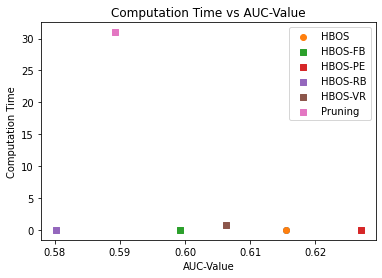

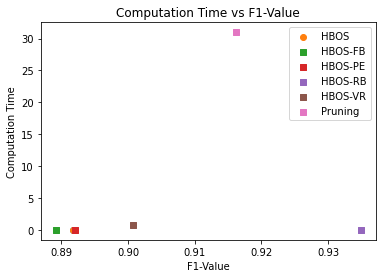

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


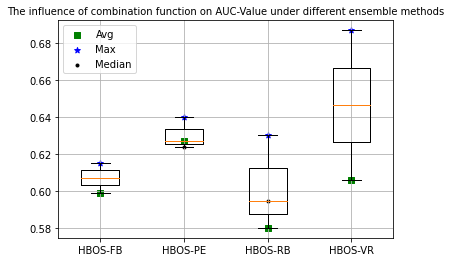

In [47]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_hbos,auc_fb_hbos, auc_pe_hbos, auc_rb_hbos , auc_vr_hbos, auc_pr]
y = [time_test_hbos,time_test_fb_hbos, time_test_pe_hbos, time_test_rb_hbos, time_test_vr_hbos, time_test_pr]
ax.scatter(x, y)  
txt = ['HBOS', 'HBOS-FB',  'HBOS-PE', 'HBOS-RB', 'HBOS-VR', 'Pruning']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_hbos,f1_fb_hbos, f1_pe_hbos, f1_rb_hbos , f1_vr_hbos,f1_pr]
y = [time_test_hbos,time_test_fb_hbos, time_test_pe_hbos, time_test_rb_hbos, time_test_vr_hbos, time_test_pr]
ax.scatter(x, y)  
txt = ['HBOS', 'HBOS-FB',  'HBOS-PE', 'HBOS-RB', 'HBOS-VR','Pruning']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()
#######

labels ='HBOS-FB', "HBOS-PE", 'HBOS-RB','HBOS-VR'
A = [auc_fb_hbos,auc_fb1_hbos]
B = [auc_pe_hbos, auc_pe1_hbos, auc_pe2_hbos]
C = [auc_rb_hbos, auc_rb1_hbos, auc_rb2_hbos]
D = [auc_vr_hbos,auc_vr1_hbos]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10,},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_hbos,auc_pe_hbos,auc_rb_hbos,auc_vr_hbos],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_hbos,auc_pe1_hbos,auc_rb1_hbos,auc_vr1_hbos],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_hbos,auc_rb2_hbos],label="Median",marker='.',c='k')
plt.legend()
plt.show()

In [48]:
# ##################################One-Class SVM
#ocsvm
fpr_ocsvm, tpr_ocsvm, f1_ocsvm, auc_ocsvm,time_train_ocsvm,time_test_ocsvm, recall_ocsvm, accuracy_ocsvm =baseline(X_train, X_test, y_train, y_test,model="ocsvm")


Base Detector:ocsvm
Total time:  1.5769102573394775 s.

Training set:

Confusion Matrix : 
 [[2902  283]
 [ 120   53]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      3185
           1       0.16      0.31      0.21       173

    accuracy                           0.88      3358
   macro avg       0.56      0.61      0.57      3358
weighted avg       0.92      0.88      0.90      3358

Area Under Curve : 
 0.6087521891815864

Test set:

Confusion Matrix : 
 [[2816  379]
 [ 111   52]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      3195
           1       0.12      0.32      0.18       163

    accuracy                           0.85      3358
   macro avg       0.54      0.60      0.55      3358
weighted avg       0.92      0.85      0.88      3358

Area Under Curve : 
 0.6001977783538311


In [49]:
#feature bagging
fpr_fb_ocsvm, tpr_fb_ocsvm, f1_fb_ocsvm, auc_fb_ocsvm,time_train_fb_ocsvm,time_test_fb_ocsvm, recall_fb_ocsvm, accuracy_fb_ocsvm =feature_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm")


Feature Bagging:
Total time:  15.477885246276855 s.
training set:
Confusion Matrix : 
 [[2903  282]
 [ 119   54]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      3185
           1       0.16      0.31      0.21       173

    accuracy                           0.88      3358
   macro avg       0.56      0.61      0.57      3358
weighted avg       0.92      0.88      0.90      3358

Area Under Curve : 
 0.6117993484632626
test set:
Confusion Matrix : 
 [[2808  387]
 [ 114   49]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      3195
           1       0.11      0.30      0.16       163

    accuracy                           0.85      3358
   macro avg       0.54      0.59      0.54      3358
weighted avg       0.92      0.85      0.88      3358

Area Under Curve : 
 0.5897433681845675
f1: 0.8814735064501775 auc: 0.589743368184

In [50]:
fpr_fb1_ocsvm, tpr_fb1_ocsvm, f1_fb1_ocsvm, auc_fb1_ocsvm,time_train_fb1_max_ocsvm,time_test_fb1_max_ocsvm, recall_fb1_ocsvm, accuracy_fb1_ocsvm=feature_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="max")


Feature Bagging:
Total time:  16.18591833114624 s.
training set:
Confusion Matrix : 
 [[2909  276]
 [ 113   60]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      3185
           1       0.18      0.35      0.24       173

    accuracy                           0.88      3358
   macro avg       0.57      0.63      0.59      3358
weighted avg       0.92      0.88      0.90      3358

Area Under Curve : 
 0.63008230415332
test set:
Confusion Matrix : 
 [[2826  369]
 [ 108   55]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      3195
           1       0.13      0.34      0.19       163

    accuracy                           0.86      3358
   macro avg       0.55      0.61      0.55      3358
weighted avg       0.92      0.86      0.89      3358

Area Under Curve : 
 0.6109651775684783
f1: 0.8865064791956196 auc: 0.610965177568478

In [51]:
#parameter ensemble
fpr_pe_ocsvm, tpr_pe_ocsvm, f1_pe_ocsvm, auc_pe_ocsvm,time_train_pe_ocsvm,time_test_pe_ocsvm, recall_pe_ocsvm, accuracy_pe_ocsvm=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="ocsvm")


parameter ensemble:
Confusion Matrix : 
 [[2816  379]
 [ 111   52]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      3195
           1       0.12      0.32      0.18       163

    accuracy                           0.85      3358
   macro avg       0.54      0.60      0.55      3358
weighted avg       0.92      0.85      0.88      3358

Area Under Curve : 
 0.6001977783538311
parameter ensemble:
Confusion Matrix : 
 [[2816  379]
 [ 111   52]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      3195
           1       0.12      0.32      0.18       163

    accuracy                           0.85      3358
   macro avg       0.54      0.60      0.55      3358
weighted avg       0.92      0.85      0.88      3358

Area Under Curve : 
 0.6001977783538311
parameter ensemble:
Confusion Matrix : 
 [[2816  379]
 [ 111   52]]
Classifica

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [52]:
fpr_pe1_ocsvm, tpr_pe1_ocsvm, f1_pe1_ocsvm, auc_pe1_ocsvm,time_train_pe1_max_ocsvm,time_test_pe1_max_ocsvm, recall_pe1_ocsvm, accuracy_pe1_ocsvm=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[2816  379]
 [ 111   52]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      3195
           1       0.12      0.32      0.18       163

    accuracy                           0.85      3358
   macro avg       0.54      0.60      0.55      3358
weighted avg       0.92      0.85      0.88      3358

Area Under Curve : 
 0.6001977783538311
parameter ensemble:
Confusion Matrix : 
 [[2816  379]
 [ 111   52]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      3195
           1       0.12      0.32      0.18       163

    accuracy                           0.85      3358
   macro avg       0.54      0.60      0.55      3358
weighted avg       0.92      0.85      0.88      3358

Area Under Curve : 
 0.6001977783538311
parameter ensemble:
Confusion Matrix : 
 [[2816  379]
 [ 111   52]]
Classifica

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [53]:
fpr_pe2_ocsvm, tpr_pe2_ocsvm, f1_pe2_ocsvm, auc_pe2_ocsvm,time_train_pe2_median_ocsvm,time_test_pe2_median_ocsvm, recall_pe2_ocsvm, accuracy_pe2_ocsvm=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[2816  379]
 [ 111   52]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      3195
           1       0.12      0.32      0.18       163

    accuracy                           0.85      3358
   macro avg       0.54      0.60      0.55      3358
weighted avg       0.92      0.85      0.88      3358

Area Under Curve : 
 0.6001977783538311
parameter ensemble:
Confusion Matrix : 
 [[2816  379]
 [ 111   52]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      3195
           1       0.12      0.32      0.18       163

    accuracy                           0.85      3358
   macro avg       0.54      0.60      0.55      3358
weighted avg       0.92      0.85      0.88      3358

Area Under Curve : 
 0.6001977783538311
parameter ensemble:
Confusion Matrix : 
 [[2816  379]
 [ 111   52]]
Classifica

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [54]:
#rotated bagging
fpr_rb_ocsvm, tpr_rb_ocsvm, f1_rb_ocsvm, auc_rb_ocsvm,time_train_rb_ocsvm,time_test_rb_ocsvm, recall_rb_ocsvm, accuracy_rb_ocsvm=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm")


Confusion Matrix : 
 [[2880  315]
 [ 115   48]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      3195
           1       0.13      0.29      0.18       163

    accuracy                           0.87      3358
   macro avg       0.55      0.60      0.56      3358
weighted avg       0.92      0.87      0.89      3358

Area Under Curve : 
 0.5979434891557937
Confusion Matrix : 
 [[2870  325]
 [ 109   54]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      3195
           1       0.14      0.33      0.20       163

    accuracy                           0.87      3358
   macro avg       0.55      0.61      0.56      3358
weighted avg       0.92      0.87      0.89      3358

Area Under Curve : 
 0.6147834519043366
Confusion Matrix : 
 [[2913  282]
 [ 118   45]]
Classification Report : 
               precision    recall  f1-score 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [55]:
fpr_rb1_ocsvm, tpr_rb1_ocsvm, f1_rb1_ocsvm, auc_rb1_ocsvm,time_train_rb1_max_ocsvm,time_test_rb1_max_ocsvm, recall_rb1_ocsvm, accuracy_rb1_ocsvm=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="max")


Confusion Matrix : 
 [[2903  292]
 [ 108   55]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      3195
           1       0.16      0.34      0.22       163

    accuracy                           0.88      3358
   macro avg       0.56      0.62      0.58      3358
weighted avg       0.93      0.88      0.90      3358

Area Under Curve : 
 0.6230152558157397
Confusion Matrix : 
 [[2908  287]
 [ 122   41]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.93      3195
           1       0.12      0.25      0.17       163

    accuracy                           0.88      3358
   macro avg       0.54      0.58      0.55      3358
weighted avg       0.92      0.88      0.90      3358

Area Under Curve : 
 0.5808529431531245
Confusion Matrix : 
 [[2929  266]
 [ 127   36]]
Classification Report : 
               precision    recall  f1-score 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [56]:
fpr_rb2_ocsvm, tpr_rb2_ocsvm, f1_rb2_ocsvm, auc_rb2_ocsvm,time_train_rb2_median_ocsvm,time_test_rb2_median_ocsvm, recall_rb2_ocsvm, accuracy_rb2_ocsvm=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="median")


Confusion Matrix : 
 [[2926  269]
 [ 113   50]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94      3195
           1       0.16      0.31      0.21       163

    accuracy                           0.89      3358
   macro avg       0.56      0.61      0.57      3358
weighted avg       0.92      0.89      0.90      3358

Area Under Curve : 
 0.6112772065247655
Confusion Matrix : 
 [[2928  267]
 [ 115   48]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94      3195
           1       0.15      0.29      0.20       163

    accuracy                           0.89      3358
   macro avg       0.56      0.61      0.57      3358
weighted avg       0.92      0.89      0.90      3358

Area Under Curve : 
 0.6054552262449956
Confusion Matrix : 
 [[2912  283]
 [ 115   48]]
Classification Report : 
               precision    recall  f1-score 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [57]:
#variable sampling with rotated bagging
fpr_vr_ocsvm, tpr_vr_ocsvm, f1_vr_ocsvm, auc_vr_ocsvm,time_train_vr_ocsvm,time_test_vr_ocsvm, recall_vr_ocsvm, accuracy_vr_ocsvm=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="ocsvm",threshold=1.2,loop=100)


Confusion Matrix : 
 [[2917  268]
 [ 121   52]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94      3185
           1       0.16      0.30      0.21       173

    accuracy                           0.88      3358
   macro avg       0.56      0.61      0.57      3358
weighted avg       0.92      0.88      0.90      3358

Area Under Curve : 
 0.6082168038402556
Confusion Matrix : 
 [[2852  343]
 [ 113   50]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.89      0.93      3195
           1       0.13      0.31      0.18       163

    accuracy                           0.86      3358
   macro avg       0.54      0.60      0.55      3358
weighted avg       0.92      0.86      0.89      3358

Area Under Curve : 
 0.5996966118455793
VR Total time:  3.7879717350006104 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [58]:
fpr_vr1_ocsvm, tpr_vr1_ocsvm, f1_vr1_ocsvm, auc_vr1_ocsvm,time_train_vr1_max_ocsvm,time_test_vr1_max_ocsvm, recall_vr1_ocsvm, accuracy_vr1_ocsvm=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="ocsvm",combination_function="max",threshold=1.2,loop=100)


Confusion Matrix : 
 [[2791  394]
 [ 107   66]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      3185
           1       0.14      0.38      0.21       173

    accuracy                           0.85      3358
   macro avg       0.55      0.63      0.56      3358
weighted avg       0.92      0.85      0.88      3358

Area Under Curve : 
 0.6288990118057005
Confusion Matrix : 
 [[2722  473]
 [ 102   61]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.85      0.90      3195
           1       0.11      0.37      0.18       163

    accuracy                           0.83      3358
   macro avg       0.54      0.61      0.54      3358
weighted avg       0.92      0.83      0.87      3358

Area Under Curve : 
 0.6130946551840011
VR Total time:  3.836313486099243 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


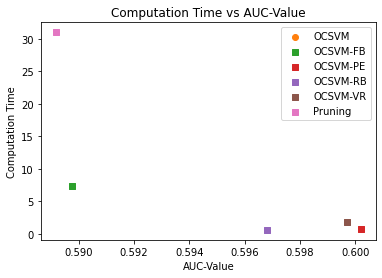

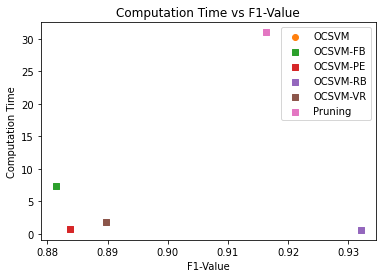

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


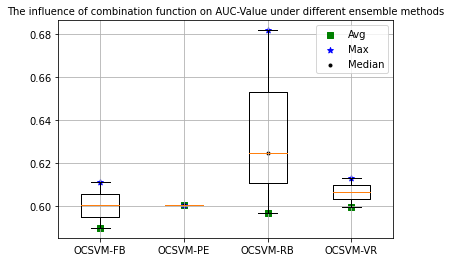

In [59]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_ocsvm,auc_fb_ocsvm, auc_pe_ocsvm, auc_rb_ocsvm , auc_vr_ocsvm, auc_pr]
y = [time_test_ocsvm,time_test_fb_ocsvm, time_test_pe_ocsvm, time_test_rb_ocsvm, time_test_vr_ocsvm, time_test_pr]
ax.scatter(x, y)  
txt = ['OCSVM', 'OCSVM-FB',  'OCSVM-PE', 'OCSVM-RB', 'OCSVM-VR','Pruning']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_ocsvm,f1_fb_ocsvm, f1_pe_ocsvm, f1_rb_ocsvm , f1_vr_ocsvm, f1_pr]
y = [time_test_ocsvm,time_test_fb_ocsvm, time_test_pe_ocsvm, time_test_rb_ocsvm, time_test_vr_ocsvm, time_test_pr]
ax.scatter(x, y)  
txt = ['OCSVM', 'OCSVM-FB',  'OCSVM-PE', 'OCSVM-RB', 'OCSVM-VR','Pruning']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()


labels ='OCSVM-FB', "OCSVM-PE", 'OCSVM-RB','OCSVM-VR'

A = [auc_fb_ocsvm,auc_fb1_ocsvm]
B = [auc_pe_ocsvm, auc_pe1_ocsvm, auc_pe2_ocsvm]
C = [auc_rb_ocsvm, auc_rb1_ocsvm, auc_rb2_ocsvm]
D = [auc_vr_ocsvm,auc_vr1_ocsvm]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10,},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_ocsvm,auc_pe_ocsvm,auc_rb_ocsvm,auc_vr_ocsvm],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_ocsvm,auc_pe1_ocsvm,auc_rb1_ocsvm,auc_vr1_ocsvm],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_ocsvm,auc_rb2_ocsvm],label="Median",marker='.',c='k')
#
plt.legend()
plt.show()


In [60]:
##################################IForest
#iforest
fpr_ifo, tpr_ifo, f1_ifo, auc_ifo,time_train_ifo,time_test_ifo,recall_ifo, accuracy_ifo =baseline(X_train, X_test, y_train, y_test,model="iforest")


Base Detector:iforest
Total time:  0.8648045063018799 s.

Training set:

Confusion Matrix : 
 [[2896  289]
 [ 126   47]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.93      3185
           1       0.14      0.27      0.18       173

    accuracy                           0.88      3358
   macro avg       0.55      0.59      0.56      3358
weighted avg       0.92      0.88      0.89      3358

Area Under Curve : 
 0.5904692334915291

Test set:

Confusion Matrix : 
 [[2823  372]
 [ 103   60]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      3195
           1       0.14      0.37      0.20       163

    accuracy                           0.86      3358
   macro avg       0.55      0.63      0.56      3358
weighted avg       0.92      0.86      0.89      3358

Area Under Curve : 
 0.6258331173132867


In [61]:
#feature bagging
fpr_fb_ifo, tpr_fb_ifo, f1_fb_ifo, auc_fb_ifo,time_train_fb_ifo,time_test_fb_ifo,recall_fb_ifo, accuracy_fb_ifo=feature_bagging(X_train, X_test, y_train, y_test,basemodel="iforest")


Feature Bagging:
Total time:  8.22026801109314 s.
training set:
Confusion Matrix : 
 [[2910  275]
 [ 112   61]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      3185
           1       0.18      0.35      0.24       173

    accuracy                           0.88      3358
   macro avg       0.57      0.63      0.59      3358
weighted avg       0.92      0.88      0.90      3358

Area Under Curve : 
 0.633129463434996
test set:
Confusion Matrix : 
 [[2832  363]
 [ 107   56]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      3195
           1       0.13      0.34      0.19       163

    accuracy                           0.86      3358
   macro avg       0.55      0.61      0.56      3358
weighted avg       0.92      0.86      0.89      3358

Area Under Curve : 
 0.6149716293672053
f1: 0.8878975783171602 auc: 0.614971629367205

In [62]:
fpr_fb1_ifo, tpr_fb1_ifo, f1_fb1_ifo, auc_fb1_ifo,time_train_fb1_max_ifo,time_test_fb1_max_ifo,recall_fb1_ifo, accuracy_fb1_ifo=feature_bagging(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="max")


Feature Bagging:
Total time:  8.193558692932129 s.
training set:
Confusion Matrix : 
 [[2901  284]
 [ 121   52]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.93      3185
           1       0.15      0.30      0.20       173

    accuracy                           0.88      3358
   macro avg       0.56      0.61      0.57      3358
weighted avg       0.92      0.88      0.90      3358

Area Under Curve : 
 0.6057050298999102
test set:
Confusion Matrix : 
 [[2851  344]
 [ 109   54]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.89      0.93      3195
           1       0.14      0.33      0.19       163

    accuracy                           0.87      3358
   macro avg       0.55      0.61      0.56      3358
weighted avg       0.92      0.87      0.89      3358

Area Under Curve : 
 0.6118100559731944
f1: 0.8907777938849761 auc: 0.6118100559731

In [63]:
#parameter ensemble
fpr_pe_ifo, tpr_pe_ifo, f1_pe_ifo, auc_pe_ifo,time_train_pe_ifo,time_test_pe_ifo,recall_pe_ifo, accuracy_pe_ifo=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="iforest")


parameter ensemble:
Confusion Matrix : 
 [[2822  373]
 [ 109   54]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      3195
           1       0.13      0.33      0.18       163

    accuracy                           0.86      3358
   macro avg       0.54      0.61      0.55      3358
weighted avg       0.92      0.86      0.89      3358

Area Under Curve : 
 0.6072717148151348
parameter ensemble:
Confusion Matrix : 
 [[2865  330]
 [ 111   52]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      3195
           1       0.14      0.32      0.19       163

    accuracy                           0.87      3358
   macro avg       0.55      0.61      0.56      3358
weighted avg       0.92      0.87      0.89      3358

Area Under Curve : 
 0.6078660099657247
parameter ensemble:
Confusion Matrix : 
 [[2838  357]
 [ 111   52]]
Classifica

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [64]:
fpr_pe1_ifo, tpr_pe1_ifo, f1_pe1_ifo, auc_pe1_ifo,time_train_pe1_max_ifo,time_test_pe1_max_ifo,recall_pe1_ifo, accuracy_pe1_ifo=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[2825  370]
 [ 104   59]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      3195
           1       0.14      0.36      0.20       163

    accuracy                           0.86      3358
   macro avg       0.55      0.62      0.56      3358
weighted avg       0.92      0.86      0.89      3358

Area Under Curve : 
 0.6230786216960935
parameter ensemble:
Confusion Matrix : 
 [[2818  377]
 [ 108   55]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      3195
           1       0.13      0.34      0.18       163

    accuracy                           0.86      3358
   macro avg       0.55      0.61      0.55      3358
weighted avg       0.92      0.86      0.89      3358

Area Under Curve : 
 0.6097132213869447
parameter ensemble:
Confusion Matrix : 
 [[2824  371]
 [ 108   55]]
Classifica

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [65]:
fpr_pe2_ifo, tpr_pe2_ifo, f1_pe2_ifo, auc_pe2_ifo,time_train_pe2_median_ifo,time_test_pe2_median_ifo,recall_pe2_ifo, accuracy_pe2_ifo=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[2860  335]
 [ 113   50]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      3195
           1       0.13      0.31      0.18       163

    accuracy                           0.87      3358
   macro avg       0.55      0.60      0.55      3358
weighted avg       0.92      0.87      0.89      3358

Area Under Curve : 
 0.6009485680271129
parameter ensemble:
Confusion Matrix : 
 [[2814  381]
 [ 116   47]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      3195
           1       0.11      0.29      0.16       163

    accuracy                           0.85      3358
   macro avg       0.54      0.58      0.54      3358
weighted avg       0.92      0.85      0.88      3358

Area Under Curve : 
 0.5845473659955644
parameter ensemble:
Confusion Matrix : 
 [[2823  372]
 [ 107   56]]
Classifica

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [66]:
#rotated bagging
fpr_rb_ifo, tpr_rb_ifo, f1_rb_ifo, auc_rb_ifo,time_train_rb_ifo,time_test_rb_ifo,recall_rb_ifo, accuracy_rb_ifo=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="iforest")


Confusion Matrix : 
 [[2889  306]
 [ 124   39]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      3195
           1       0.11      0.24      0.15       163

    accuracy                           0.87      3358
   macro avg       0.54      0.57      0.54      3358
weighted avg       0.92      0.87      0.89      3358

Area Under Curve : 
 0.5717445778968289
Confusion Matrix : 
 [[2902  293]
 [ 111   52]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.93      3195
           1       0.15      0.32      0.20       163

    accuracy                           0.88      3358
   macro avg       0.56      0.61      0.57      3358
weighted avg       0.92      0.88      0.90      3358

Area Under Curve : 
 0.613656307305318
Confusion Matrix : 
 [[2929  266]
 [ 110   53]]
Classification Report : 
               precision    recall  f1-score  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [67]:
fpr_rb1_ifo, tpr_rb1_ifo, f1_rb1_ifo, auc_rb1_ifo,time_train_rb1_max_ifo,time_test_rb1_max_ifo,recall_rb1_ifo, accuracy_rb1_ifo=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="max")


Confusion Matrix : 
 [[2889  306]
 [ 116   47]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      3195
           1       0.13      0.29      0.18       163

    accuracy                           0.87      3358
   macro avg       0.55      0.60      0.56      3358
weighted avg       0.92      0.87      0.90      3358

Area Under Curve : 
 0.5962844551974423
Confusion Matrix : 
 [[2921  274]
 [ 119   44]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      3195
           1       0.14      0.27      0.18       163

    accuracy                           0.88      3358
   macro avg       0.55      0.59      0.56      3358
weighted avg       0.92      0.88      0.90      3358

Area Under Curve : 
 0.5920898259358468
Confusion Matrix : 
 [[2885  310]
 [ 117   46]]
Classification Report : 
               precision    recall  f1-score 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [68]:
fpr_rb2_ifo, tpr_rb2_ifo, f1_rb2_ifo, auc_rb2_ifo,time_train_rb2_median_ifo,time_test_rb2_median_ifo,recall_rb2_ifo, accuracy_rb2_ifo=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="median")


Confusion Matrix : 
 [[2897  298]
 [ 117   46]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.93      3195
           1       0.13      0.28      0.18       163

    accuracy                           0.88      3358
   macro avg       0.55      0.59      0.56      3358
weighted avg       0.92      0.88      0.90      3358

Area Under Curve : 
 0.5944689267163993
Confusion Matrix : 
 [[2882  313]
 [ 124   39]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      3195
           1       0.11      0.24      0.15       163

    accuracy                           0.87      3358
   macro avg       0.53      0.57      0.54      3358
weighted avg       0.92      0.87      0.89      3358

Area Under Curve : 
 0.5706491162379869
Confusion Matrix : 
 [[2910  285]
 [ 110   53]]
Classification Report : 
               precision    recall  f1-score 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [69]:
#variable sampling with rotated bagging
fpr_vr_ifo, tpr_vr_ifo, f1_vr_ifo, auc_vr_ifo,time_train_vr_ifo,time_test_vr_ifo,recall_vr_ifo, accuracy_vr_ifo=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="iforest",threshold=1.2,loop=100)


Confusion Matrix : 
 [[2914  271]
 [ 119   54]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      3185
           1       0.17      0.31      0.22       173

    accuracy                           0.88      3358
   macro avg       0.56      0.61      0.58      3358
weighted avg       0.92      0.88      0.90      3358

Area Under Curve : 
 0.61352619304725
Confusion Matrix : 
 [[2860  335]
 [ 111   52]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      3195
           1       0.13      0.32      0.19       163

    accuracy                           0.87      3358
   macro avg       0.55      0.61      0.56      3358
weighted avg       0.92      0.87      0.89      3358

Area Under Curve : 
 0.6070835373522663
VR Total time:  32.54572677612305 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [70]:
fpr_vr1_ifo, tpr_vr1_ifo, f1_vr1_ifo, auc_vr1_ifo,time_train_vr1_max_ifo,time_test_vr1_max_ifo,recall_vr1_ifo, accuracy_vr1_ifo=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="iforest",combination_function="max",threshold=1.2,loop=100)


Confusion Matrix : 
 [[2526  659]
 [  84   89]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.79      0.87      3185
           1       0.12      0.51      0.19       173

    accuracy                           0.78      3358
   macro avg       0.54      0.65      0.53      3358
weighted avg       0.92      0.78      0.84      3358

Area Under Curve : 
 0.6537717443580368
Confusion Matrix : 
 [[2443  752]
 [  82   81]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.76      0.85      3195
           1       0.10      0.50      0.16       163

    accuracy                           0.75      3358
   macro avg       0.53      0.63      0.51      3358
weighted avg       0.93      0.75      0.82      3358

Area Under Curve : 
 0.6307823766045489
VR Total time:  31.62135910987854 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


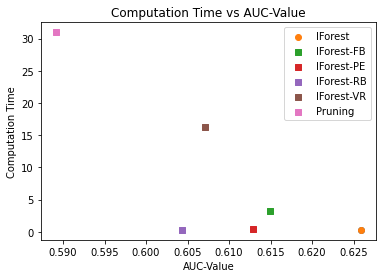

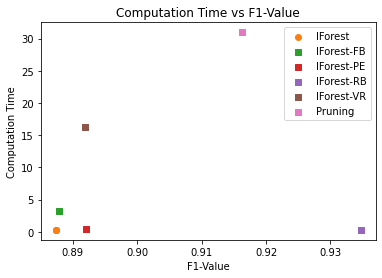

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


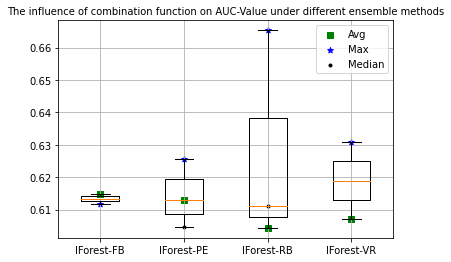

In [71]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_ifo,auc_fb_ifo, auc_pe_ifo, auc_rb_ifo , auc_vr_ifo,auc_pr]
y = [time_test_ifo,time_test_fb_ifo, time_test_pe_ifo, time_test_rb_ifo, time_test_vr_ifo, time_test_pr]
ax.scatter(x, y)  
txt = ['IForest', 'IForest-FB',  'IForest-PE', 'IForest-RB', 'IForest-VR','Pruning']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_ifo,f1_fb_ifo, f1_pe_ifo, f1_rb_ifo , f1_vr_ifo,f1_pr]
y = [time_test_ifo,time_test_fb_ifo, time_test_pe_ifo, time_test_rb_ifo, time_test_vr_ifo, time_test_pr]
ax.scatter(x, y)  
txt = ['IForest', 'IForest-FB',  'IForest-PE', 'IForest-RB', 'IForest-VR','Pruning']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()


labels ='IForest-FB', "IForest-PE", 'IForest-RB','IForest-VR'

A = [auc_fb_ifo,auc_fb1_ifo]
B = [auc_pe_ifo, auc_pe1_ifo, auc_pe2_ifo]
C = [auc_rb_ifo, auc_rb1_ifo, auc_rb2_ifo]
D = [auc_vr_ifo,auc_vr1_ifo]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10,},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_ifo,auc_pe_ifo,auc_rb_ifo,auc_vr_ifo],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_ifo,auc_pe1_ifo,auc_rb1_ifo,auc_vr1_ifo],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_ifo,auc_rb2_ifo],label="Median",marker='.',c='k')

plt.legend()
plt.show()


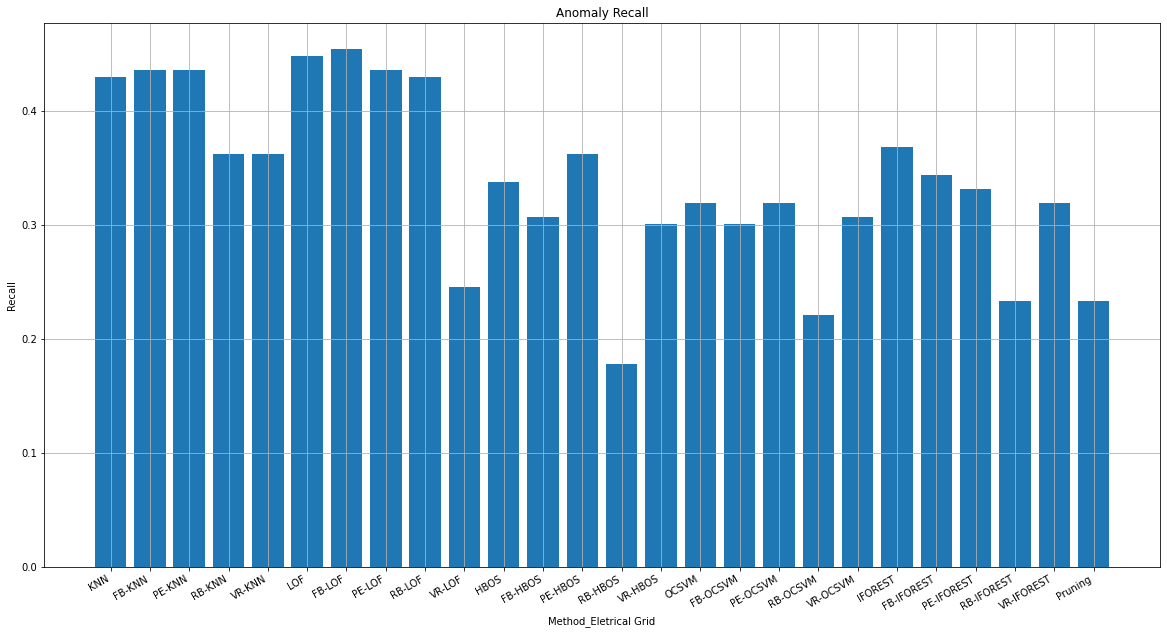

In [72]:
## recall ##
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10


y = [recall_knn,recall_fb_knn,recall_pe_knn,recall_rb_knn,recall_vr_knn,
     recall_lof,recall_fb_lof,recall_pe_lof,recall_rb_lof,recall_vr_lof,
     recall_hbos,recall_fb_hbos,recall_pe_hbos,recall_rb_hbos,recall_vr_hbos,
     recall_ocsvm,recall_fb_ocsvm,recall_pe_ocsvm,recall_rb_ocsvm,recall_vr_ocsvm,
     recall_ifo,recall_fb_ifo,recall_pe_ifo,recall_rb_ifo,recall_vr_ifo, recall_pr]
x = ['KNN','FB-KNN','PE-KNN','RB-KNN','VR-KNN',
     'LOF','FB-LOF','PE-LOF','RB-LOF','VR-LOF',
     'HBOS','FB-HBOS','PE-HBOS','RB-HBOS','VR-HBOS',
     'OCSVM','FB-OCSVM','PE-OCSVM','RB-OCSVM','VR-OCSVM',
     'IFOREST','FB-IFOREST','PE-IFOREST','RB-IFOREST','VR-IFOREST','Pruning']
ax= plt.subplot()
fig = plt.bar(x,y)
#plt.xticks(x,y)
plt.title("Anomaly Recall")
plt.xlabel("Method_Eletrical Grid")
plt.ylabel("Recall")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.grid()
plt.show()




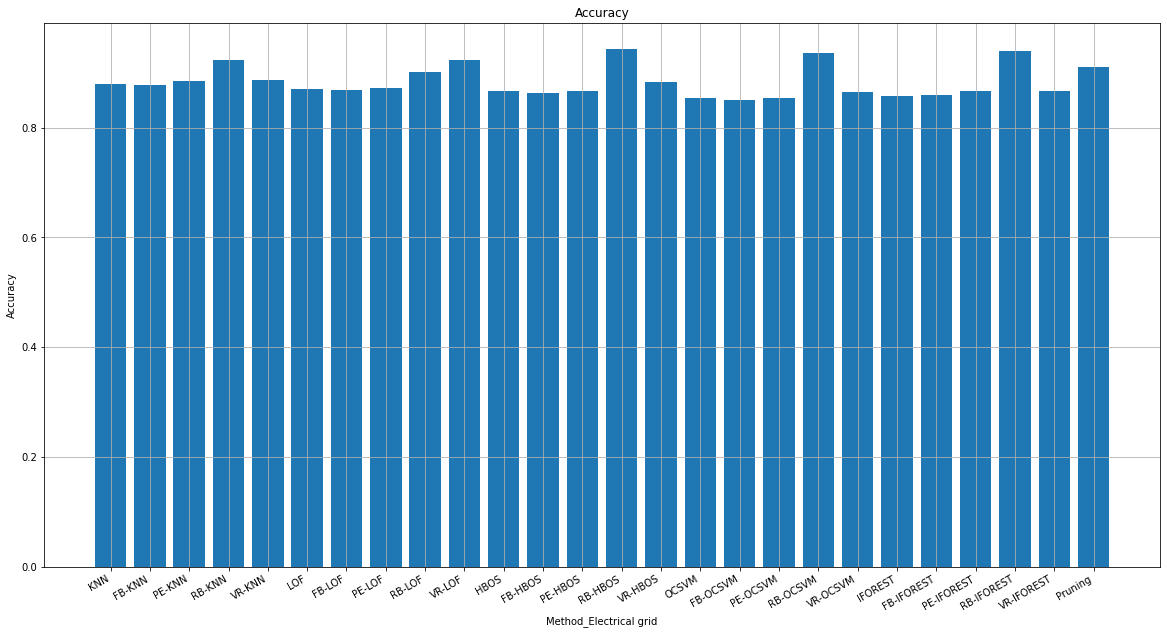

In [73]:
## Accuracy ##
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10


y = [accuracy_knn,accuracy_fb_knn,accuracy_pe_knn,accuracy_rb_knn,accuracy_vr_knn,
     accuracy_lof,accuracy_fb_lof,accuracy_pe_lof,accuracy_rb_lof,accuracy_vr_lof,
     accuracy_hbos,accuracy_fb_hbos,accuracy_pe_hbos,accuracy_rb_hbos,accuracy_vr_hbos,
     accuracy_ocsvm,accuracy_fb_ocsvm,accuracy_pe_ocsvm,accuracy_rb_ocsvm,accuracy_vr_ocsvm,
     accuracy_ifo,accuracy_fb_ifo,accuracy_pe_ifo,accuracy_rb_ifo,accuracy_vr_ifo, accuracy_pr]
x = ['KNN','FB-KNN','PE-KNN','RB-KNN','VR-KNN',
     'LOF','FB-LOF','PE-LOF','RB-LOF','VR-LOF',
     'HBOS','FB-HBOS','PE-HBOS','RB-HBOS','VR-HBOS',
     'OCSVM','FB-OCSVM','PE-OCSVM','RB-OCSVM','VR-OCSVM',
     'IFOREST','FB-IFOREST','PE-IFOREST','RB-IFOREST','VR-IFOREST','Pruning']

ax= plt.subplot()
fig = plt.bar(x,y)
#plt.xticks(x,y)
plt.title("Accuracy")
plt.xlabel("Method_Electrical grid")
plt.ylabel("Accuracy")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.grid()
plt.show()

In [74]:
model_performance = pd.DataFrame(columns=['Accuracy','Recall','AUC','F1-Score','total time'])

model_performance.loc['KNN'] = [accuracy_knn, recall_knn, auc_knn, f1_knn,time_test_knn+time_train_knn]
model_performance.loc['FB-KNN_MEAN'] = [accuracy_fb_knn, recall_fb_knn, auc_fb_knn, f1_fb_knn,time_test_fb_knn+time_train_fb_knn]
model_performance.loc['FB-KNN_MAX'] = [accuracy_fb1_knn, recall_fb1_knn, auc_fb1_knn, f1_fb1_knn,time_test_fb1_max_knn+time_train_fb1_max_knn]
model_performance.loc['PE-KNN_MEAN'] = [accuracy_pe_knn, recall_pe_knn, auc_pe_knn, f1_pe_knn,time_test_pe_knn+time_train_pe_knn]
model_performance.loc['PE-KNN_MAX'] = [accuracy_pe1_knn, recall_pe1_knn, auc_pe1_knn, f1_pe1_knn,time_test_pe1_max_knn+time_train_pe1_max_knn]
model_performance.loc['PE-KNN_MEDIAN'] = [accuracy_pe2_knn, recall_pe2_knn, auc_pe2_knn, f1_pe2_knn,time_test_pe2_median_knn+time_train_pe2_median_knn]
model_performance.loc['RB-KNN_MEAN'] = [accuracy_rb_knn, recall_rb_knn, auc_rb_knn, f1_rb_knn,time_test_rb_knn+time_train_rb_knn]
model_performance.loc['RB-KNN_MAX'] = [accuracy_rb1_knn, recall_rb1_knn, auc_rb1_knn, f1_rb1_knn,time_test_rb1_max_knn+time_train_rb1_max_knn]
model_performance.loc['RB-KNN_MEDIAN'] = [accuracy_rb2_knn, recall_rb2_knn, auc_rb2_knn, f1_rb2_knn,time_test_rb2_median_knn+time_train_rb2_median_knn]
model_performance.loc['VR-KNN_MEAN'] = [accuracy_vr_knn, recall_vr_knn, auc_vr_knn, f1_vr_knn,time_test_vr_knn+time_train_vr_knn]
model_performance.loc['VR-KNN_MAX'] = [accuracy_vr1_knn, recall_vr1_knn, auc_vr1_knn, f1_vr1_knn,time_test_vr1_max_knn+time_train_vr1_max_knn]

model_performance.loc['LOF'] = [accuracy_lof, recall_lof, auc_lof, f1_lof,time_test_lof+time_train_lof]
model_performance.loc['FB-LOF_MEAN'] = [accuracy_fb_lof, recall_fb_lof, auc_fb_lof, f1_fb_lof,time_test_fb_lof+time_train_fb_lof]
model_performance.loc['FB-LOF_MAX'] = [accuracy_fb1_lof, recall_fb1_lof, auc_fb1_lof, f1_fb1_lof,time_test_fb1_max_lof+time_train_fb1_max_lof]
model_performance.loc['PE-LOF_MEAN'] = [accuracy_pe_lof, recall_pe_lof, auc_pe_lof, f1_pe_lof,time_test_pe_lof+time_train_pe_lof]
model_performance.loc['PE-LOF_MAX'] = [accuracy_pe1_lof, recall_pe1_lof, auc_pe1_lof, f1_pe1_lof,time_test_pe1_max_lof+time_train_pe1_max_lof]
model_performance.loc['PE-LOF_MEDIAN'] = [accuracy_pe2_lof, recall_pe2_lof, auc_pe2_lof, f1_pe2_lof,time_test_pe2_median_lof+time_train_pe2_median_lof]
model_performance.loc['RB-LOF_MEAN'] = [accuracy_rb_lof, recall_rb_lof, auc_rb_lof, f1_rb_lof,time_test_rb_lof+time_train_rb_lof]
model_performance.loc['RB-LOF_MAX'] = [accuracy_rb1_lof, recall_rb1_lof, auc_rb1_lof, f1_rb1_lof,time_test_rb1_max_lof+time_train_rb1_max_lof]
model_performance.loc['RB-LOF_MEDIAN'] = [accuracy_rb2_lof, recall_rb2_lof, auc_rb2_lof, f1_rb2_lof,time_test_rb2_median_lof+time_train_rb2_median_lof]
model_performance.loc['VR-LOF_MEAN'] = [accuracy_vr_lof, recall_vr_lof, auc_vr_lof, f1_vr_lof,time_test_vr_lof+time_train_vr_lof]
model_performance.loc['VR-LOF_MAX'] = [accuracy_vr1_lof, recall_vr1_lof, auc_vr1_lof, f1_vr1_lof,time_test_vr1_max_lof+time_train_vr1_max_lof]

model_performance.loc['HBOS'] = [accuracy_hbos, recall_hbos, auc_hbos, f1_hbos,time_test_hbos+time_train_hbos]
model_performance.loc['FB-HBOS_MEAN'] = [accuracy_fb_hbos, recall_fb_hbos, auc_fb_hbos, f1_fb_hbos,time_test_fb_hbos+time_train_fb_hbos]
model_performance.loc['FB-HBOS_MAX'] = [accuracy_fb1_hbos, recall_fb1_hbos, auc_fb1_hbos, f1_fb1_hbos,time_test_fb1_max_hbos+time_train_fb1_max_hbos]
model_performance.loc['PE-HBOS_MEAN'] = [accuracy_pe_hbos, recall_pe_hbos, auc_pe_hbos, f1_pe_hbos,time_test_pe_hbos+time_train_pe_hbos]
model_performance.loc['PE-HBOS_MAX'] = [accuracy_pe1_hbos, recall_pe1_hbos, auc_pe1_hbos, f1_pe1_hbos,time_test_pe1_max_hbos+time_train_pe1_max_hbos]
model_performance.loc['PE-HBOS_MEDIAN'] = [accuracy_pe2_hbos, recall_pe2_hbos, auc_pe2_hbos, f1_pe2_hbos,time_test_pe2_median_hbos+time_train_pe2_median_hbos]
model_performance.loc['RB-HBOS_MEAN'] = [accuracy_rb_hbos, recall_rb_hbos, auc_rb_hbos, f1_rb_hbos,time_test_rb_hbos+time_train_rb_hbos]
model_performance.loc['RB-HBOS_MAX'] = [accuracy_rb1_hbos, recall_rb1_hbos, auc_rb1_hbos, f1_rb1_hbos,time_test_rb1_max_hbos+time_train_rb1_max_hbos]
model_performance.loc['RB-HBOS_MEDIAN'] = [accuracy_rb2_hbos, recall_rb2_hbos, auc_rb2_hbos, f1_rb2_hbos,time_test_rb2_median_hbos+time_train_rb2_median_hbos]
model_performance.loc['VR-HBOS_MEAN'] = [accuracy_vr_hbos, recall_vr_hbos, auc_vr_hbos, f1_vr_hbos,time_test_vr_hbos+time_train_vr_hbos]
model_performance.loc['VR-HBOS_MAX'] = [accuracy_vr1_hbos, recall_vr1_hbos, auc_vr1_hbos, f1_vr1_hbos,time_test_vr1_max_hbos+time_train_vr1_max_hbos]

model_performance.loc['OCSVM'] = [accuracy_ocsvm, recall_ocsvm, auc_ocsvm, f1_ocsvm,time_test_ocsvm+time_train_ocsvm]
model_performance.loc['FB-OCSVM_MEAN'] = [accuracy_fb_ocsvm, recall_fb_ocsvm, auc_fb_ocsvm, f1_fb_ocsvm,time_test_fb_ocsvm+time_train_fb_ocsvm]
model_performance.loc['FB-OCSVM_MAX'] = [accuracy_fb1_ocsvm, recall_fb1_ocsvm, auc_fb1_ocsvm, f1_fb1_ocsvm,time_test_fb1_max_ocsvm+time_train_fb1_max_ocsvm]
model_performance.loc['PE-OCSVM_MEAN'] = [accuracy_pe_ocsvm, recall_pe_ocsvm, auc_pe_ocsvm, f1_pe_ocsvm,time_test_pe_ocsvm+time_train_pe_ocsvm]
model_performance.loc['PE-OCSVM_MAX'] = [accuracy_pe1_ocsvm, recall_pe1_ocsvm, auc_pe1_ocsvm, f1_pe1_ocsvm,time_test_pe1_max_ocsvm+time_train_pe1_max_ocsvm]
model_performance.loc['PE-OCSVM_MEDIAN'] = [accuracy_pe2_ocsvm, recall_pe2_ocsvm, auc_pe2_ocsvm, f1_pe2_ocsvm,time_test_pe2_median_ocsvm+time_train_pe2_median_ocsvm]
model_performance.loc['RB-OCSVM_MEAN'] = [accuracy_rb_ocsvm, recall_rb_ocsvm, auc_rb_ocsvm, f1_rb_ocsvm,time_test_rb_ocsvm+time_train_rb_ocsvm]
model_performance.loc['RB-OCSVM_MAX'] = [accuracy_rb1_ocsvm, recall_rb1_ocsvm, auc_rb1_ocsvm, f1_rb1_ocsvm,time_test_rb1_max_ocsvm+time_train_rb1_max_ocsvm]
model_performance.loc['RB-OCSVM_MEDIAN'] = [accuracy_rb2_ocsvm, recall_rb2_ocsvm, auc_rb2_ocsvm, f1_rb2_ocsvm,time_test_rb2_median_ocsvm+time_train_rb2_median_ocsvm]
model_performance.loc['VR-OCSVM_MEAN'] = [accuracy_vr_ocsvm, recall_vr_ocsvm, auc_vr_ocsvm, f1_vr_ocsvm,time_test_vr_ocsvm+time_train_vr_ocsvm]
model_performance.loc['VR-OCSVM_MAX'] = [accuracy_vr1_ocsvm, recall_vr1_ocsvm, auc_vr1_ocsvm, f1_vr1_ocsvm,time_test_vr1_max_ocsvm+time_train_vr1_max_ocsvm]

model_performance.loc['IFOREST'] = [accuracy_ifo, recall_ifo, auc_ifo, f1_ifo,time_test_ifo+time_train_ifo]
model_performance.loc['FB-IFOREST_MEAN'] = [accuracy_fb_ifo, recall_fb_ifo, auc_fb_ifo, f1_fb_ifo,time_test_fb_ifo+time_train_fb_ifo]
model_performance.loc['FB-IFOREST_MAX'] = [accuracy_fb1_ifo, recall_fb1_ifo, auc_fb1_ifo, f1_fb1_ifo,time_test_fb1_max_ifo+time_train_fb1_max_ifo]
model_performance.loc['PE-IFOREST_MEAN'] = [accuracy_pe_ifo, recall_pe_ifo, auc_pe_ifo, f1_pe_ifo,time_test_pe_ifo+time_train_pe_ifo]
model_performance.loc['PE-IFOREST_MAX'] = [accuracy_pe1_ifo, recall_pe1_ifo, auc_pe1_ifo, f1_pe1_ifo,time_test_pe1_max_ifo+time_train_pe1_max_ifo]
model_performance.loc['PE-IFOREST_MEDIAN'] = [accuracy_pe2_ifo, recall_pe2_ifo, auc_pe2_ifo, f1_pe2_ifo,time_test_pe2_median_ifo+time_train_pe2_median_ifo]
model_performance.loc['RB-IFOREST_MEAN'] = [accuracy_rb_ifo, recall_rb_ifo, auc_rb_ifo, f1_rb_ifo,time_test_rb_ifo+time_train_rb_ifo]
model_performance.loc['RB-IFOREST_MAX'] = [accuracy_rb1_ifo, recall_rb1_ifo, auc_rb1_ifo, f1_rb1_ifo,time_test_rb1_max_ifo+time_train_rb1_max_ifo]
model_performance.loc['RB-IFOREST_MEDIAN'] = [accuracy_rb2_ifo, recall_rb2_ifo, auc_rb2_ifo, f1_rb2_ifo,time_test_rb2_median_ifo+time_train_rb2_median_ifo]
model_performance.loc['VR-IFOREST_MEAN'] = [accuracy_vr_ifo, recall_vr_ifo, auc_vr_ifo, f1_vr_ifo,time_test_vr_ifo+time_train_vr_ifo]
model_performance.loc['VR-IFOREST_MAX'] = [accuracy_vr1_ifo, recall_vr1_ifo, auc_vr1_ifo, f1_vr1_ifo,time_test_vr1_max_ifo+time_train_vr1_max_ifo]


model_performance.loc['Pruning'] = [accuracy_pr, recall_pr, auc_pr, f1_pr,time_test_pr+time_train_pr]



In [75]:
model_performance.style.background_gradient(cmap='coolwarm').format({'Accuracy': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'AUC': '{:.2%}',
                                                                     'F1-Score': '{:.2%}',
                                                                     'total time':'{:.1f}'
                                                                     })

,Accuracy,Recall,AUC,F1-Score,total time
KNN,87.97%,42.94%,66.61%,90.17%,1.5
FB-KNN_MEAN,87.73%,43.56%,66.77%,90.03%,15.9
FB-KNN_MAX,89.01%,44.17%,67.74%,90.85%,11.4
PE-KNN_MEAN,88.42%,43.56%,67.13%,90.46%,1.5
PE-KNN_MAX,86.69%,44.79%,66.81%,89.40%,1.5
PE-KNN_MEDIAN,88.27%,44.79%,67.64%,90.39%,1.5
RB-KNN_MEAN,92.29%,36.20%,65.67%,92.78%,0.6
RB-KNN_MAX,72.25%,73.62%,72.90%,80.14%,0.6
RB-KNN_MEDIAN,93.45%,27.61%,62.21%,93.29%,0.6
VR-KNN_MEAN,88.77%,36.20%,63.83%,90.54%,2.0
